## Laboratorio de Implementacion III

#### Funciones Utiles

##### Grafica de Prediccion vs reales

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px

def plot_pred_vs_real(
    pred_file,
    real_file,
    modelo="Modelo",
    export_html=False,
    html_path="pred_vs_real.html",
    pred_col_pred="tn_predicha",
    pred_col_id="product_id",
    real_col_real="tn_real",
    real_col_id="product_id"
):
    """
    Grafica predicción vs real usando Plotly y permite exportar a HTML.

    Args:
        pred_file (str): Ruta al archivo CSV con las predicciones.
        real_file (str): Ruta al archivo con las ventas reales.
        modelo (str): Nombre del modelo utilizado (se muestra en el título).
        export_html (bool): Si True, exporta el gráfico a HTML.
        html_path (str): Ruta de salida para el archivo HTML.
        pred_col_pred (str): Columna de predicción en pred_file.
        pred_col_id (str): Columna ID en pred_file.
        real_col_real (str): Columna real en real_file (debe existir o será creada).
        real_col_id (str): Columna ID en real_file.
    """
    # Cargar predicciones
    pred = pd.read_csv(pred_file)
    pred[pred_col_id] = pred[pred_col_id].astype(str)

    # Cargar datos reales (puede ser dataset_limpio.txt)
    if real_file.endswith(".txt"):
        real = pd.read_csv(real_file, sep="\t")
    else:
        real = pd.read_csv(real_file)

    # Asegurar que 'product_id' y 'periodo' existan
    if 'product_id' not in real.columns or 'tn' not in real.columns or 'periodo' not in real.columns:
        raise ValueError("El archivo de datos reales debe contener las columnas: 'product_id', 'tn', y 'periodo'.")

    # Preprocesamiento para dataset_limpio
    real['product_id'] = real['product_id'].astype(str)
    real = real[real['periodo'] == 201912]
    real = real.groupby('product_id')['tn'].sum().reset_index()
    real = real.rename(columns={'tn': real_col_real})
    real[real_col_id] = real[real_col_id].astype(str)

    # Merge
    df = pd.merge(pred, real, left_on=pred_col_id, right_on=real_col_id, how='inner')

    if df.empty:
        print("⚠️ No hay registros coincidentes entre predicción y realidad.")
        return

    # Métricas
    rmse = np.sqrt(((df[pred_col_pred] - df[real_col_real]) ** 2).mean())
    mae = np.abs(df[pred_col_pred] - df[real_col_real]).mean()
    r2 = 1 - ((df[pred_col_pred] - df[real_col_real]) ** 2).sum() / ((df[real_col_real] - df[real_col_real].mean()) ** 2).sum()

    # Gráfico interactivo
    fig = px.scatter(
        df,
        x=real_col_real,
        y=pred_col_pred,
        hover_data=[pred_col_id, real_col_real, pred_col_pred],
        labels={real_col_real: "Ventas reales", pred_col_pred: "Predicción"},
        title=f"Predicción vs Real ({modelo})<br>RMSE={rmse:.2f} | MAE={mae:.2f} | R²={r2:.4f}"
    )

    # Línea ideal
    max_val = max(df[real_col_real].max(), df[pred_col_pred].max())
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=max_val, y1=max_val,
        line=dict(color='blue', dash='dash')
    )
    fig.update_layout(width=800, height=600)

    # Exportar
    if export_html:
        fig.write_html(html_path)
        print(f"✅ Gráfico exportado a {html_path}")

    fig.show()

##### Reconocimiento de Features 

In [5]:
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = False
):
    """
    Detecta automáticamente las columnas de features para el modelo.

    Args:
        df (pd.DataFrame): Dataset completo ya procesado.
        target_col (str): Nombre de la columna objetivo.
        drop_cols (list): Columnas adicionales a excluir (además del target).
        id_cols (list): Identificadores que pueden ser categóricos.
        verbose (bool): Si True, imprime listas encontradas.

    Returns:
        features (list): Lista de columnas finales de entrada al modelo.
        lgbm_cat_features (list): Sublista de features categóricas para LGBM.
    """
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features


### Prediccion SELLIN 202002

### Tratamiento con tn=0

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------
# 1. Cargar archivo original
# ---------------------------
sellin = pd.read_csv("sell-in.txt", sep="\t")

# Asegurar tipos correctos
sellin['periodo'] = sellin['periodo'].astype(int)
sellin['product_id'] = sellin['product_id'].astype(str)
sellin['customer_id'] = sellin['customer_id'].astype(str)

# ---------------------------
# 2. Calcular período de vida de productos y clientes
# ---------------------------
producto_periodos = sellin.groupby('product_id')['periodo'].agg(['min', 'max']).reset_index()
producto_periodos.columns = ['product_id', 'periodo_inicio_prod', 'periodo_fin_prod']
producto_periodos['periodo_fin_prod'] = producto_periodos['periodo_fin_prod'].apply(lambda x: max(x, 202002))

cliente_periodos = sellin.groupby('customer_id')['periodo'].agg(['min', 'max']).reset_index()
cliente_periodos.columns = ['customer_id', 'periodo_inicio_cli', 'periodo_fin_cli']
cliente_periodos['periodo_fin_cli'] = cliente_periodos['periodo_fin_cli'].apply(lambda x: max(x, 202002))

# ---------------------------
# 3. Crear combinaciones <product_id, customer_id, periodo>
# ---------------------------
prod_cli = pd.merge(
    sellin[['product_id', 'customer_id']].drop_duplicates(),
    producto_periodos,
    on='product_id'
)
prod_cli = pd.merge(prod_cli, cliente_periodos, on='customer_id')

prod_cli['periodo_inicio'] = prod_cli[['periodo_inicio_prod', 'periodo_inicio_cli']].max(axis=1)
prod_cli['periodo_fin'] = prod_cli[['periodo_fin_prod', 'periodo_fin_cli']].min(axis=1)

# Generar todas las combinaciones de periodo válidas por fila
rows = []
for _, row in prod_cli.iterrows():
    periodos = np.arange(row['periodo_inicio'], min(row['periodo_fin'], 202002) + 1)
    periodos = [p for p in periodos if 1 <= p % 100 <= 12]
    for periodo in periodos:
        rows.append((periodo, row['customer_id'], row['product_id']))

full_index = pd.DataFrame(rows, columns=['periodo', 'customer_id', 'product_id'])

# ---------------------------
# 4. Combinar con datos reales y completar
# ---------------------------
sellin_key = sellin[['periodo', 'customer_id', 'product_id', 'tn']]
merged = pd.merge(full_index, sellin_key, on=['periodo', 'customer_id', 'product_id'], how='left')

# Marcar los artificiales
merged['es_artificial'] = merged['tn'].isna().astype(int)

# Completar tn = 0 solo para los artificiales
merged['tn'] = merged['tn'].fillna(0)

# Ordenar
merged = merged.sort_values(by=['product_id', 'customer_id', 'periodo'])

# ---------------------------
# 5. Guardar archivo final
# ---------------------------
merged.to_csv("sellin_expandido.txt", sep="\t", index=False)
print("✅ Archivo generado: sellin_expandido.txt (completo con artificiales y reales)")

✅ Archivo generado: sellin_expandido.txt (completo con artificiales y reales)


#### Unificamos los periodos artificiales con el seellin original (aun hay q eliminar ceros en los ultimos periodos de las clases, eso se hace en el siguiente script )

### Generar lags tm-1 a tm-11 y CLASE 

In [ ]:
import pandas as pd
import numpy as np

# ------------------------------
# 1. Cargar archivo sell-in expandido
# ------------------------------
sellin_full = pd.read_csv("sellin_expandido.txt", sep="\t")
sellin_full['periodo'] = sellin_full['periodo'].astype(int)
sellin_full['product_id'] = sellin_full['product_id'].astype(str)
sellin_full['customer_id'] = sellin_full['customer_id'].astype(str)

# Ordenar por producto, cliente y periodo
sellin_full = sellin_full.sort_values(by=['product_id', 'customer_id', 'periodo'])

# ------------------------------
# 2. Generar lags y CLASE (t+2)
# ------------------------------
def generar_lags(grupo):
    for i in range(12):
        grupo[f"tm-{i}"] = grupo['tn'].shift(i)
    grupo['CLASE'] = grupo['tn'].shift(-2)

    # Marcar como NaN las clases que aún no se conocen (201911 y 201912)
    grupo.loc[grupo['periodo'].isin([201911, 201912]), 'CLASE'] = np.nan
    return grupo

sellin_lags = sellin_full.groupby(['product_id', 'customer_id'], group_keys=False).apply(generar_lags)

# ------------------------------
# 3. Guardar dataset final
# ------------------------------
sellin_lags.to_csv("dataset_lags_clase_completo.txt", sep="\t", index=False)
sellin_lags.to_csv("dataset_lags_clase_completo.csv", index=False)

print("✅ Dataset completo generado: dataset_lags_clase_completo.txt")




Tenemos el dataset con lags completo, pero con una columna que puede luego ser ignorada y eliminada que es es_artificial.

concatenamos los datasets


### Agregar product_id, stock_final y 5 lags

In [22]:
import pandas as pd
import os

# -------------------------
# 1. Cargar datasets base
# -------------------------
df = pd.read_csv("dataset_lags_clase_completo.txt", sep="\t")
productos = pd.read_csv("tb_productos.txt", sep="\t")
stocks = pd.read_csv("tb_stocks.txt", sep="\t")

df['periodo'] = df['periodo'].astype(int)
df['product_id'] = df['product_id'].astype(str)

# -------------------------
# 2. Merge con info de productos
# -------------------------
productos['product_id'] = productos['product_id'].astype(str)
df = df.merge(productos, on='product_id', how='left')

# -------------------------
# 3. Crear lags de stock
# -------------------------
stocks['periodo'] = stocks['periodo'].astype(int)
stocks['product_id'] = stocks['product_id'].astype(str)
stocks = stocks.sort_values(by=['product_id', 'periodo'])

def crear_lags_stock(grupo):
    for i in range(6):  # Ajustá el número de lags según sea necesario
        grupo[f"stock_tm-{i}"] = grupo['stock_final'].shift(i)
    return grupo

stocks_lags = stocks.groupby('product_id').apply(crear_lags_stock).reset_index(drop=True)

# Filtrar solo columnas necesarias
columnas_utiles = ['product_id', 'periodo'] + [f"stock_tm-{i}" for i in range(6)]
stocks_lags = stocks_lags[columnas_utiles]

# Merge con df principal
df = df.merge(stocks_lags, on=['product_id', 'periodo'], how='left')

# -------------------------
# 4. Guardar datasets enriquecidos
# -------------------------
df.to_csv("dataset_lags_clase_completo_con_productos_stocks.txt", sep="\t", index=False)
df.to_csv("dataset_lags_clase_completo_con_productos_stocks.csv", index=False)

print("✅ Archivo enriquecido generado: dataset_lags_clase_completo_con_productos_stocks.txt")



C:\Users\marco\AppData\Local\Temp\ipykernel_23580\278500933.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stocks_lags = stocks.groupby('product_id').apply(crear_lags_stock).reset_index(drop=True)


✅ Archivo enriquecido generado: dataset_lags_clase_completo_con_productos_stocks.txt


#### Eliminamos la variable 'es_artificial' y tm-0, con eso tenemos el esqueleto base antes del FEATURE ENGENIERIG


In [24]:
import pandas as pd

# -------------------------------
# 1. Cargar dataset intermedio
# -------------------------------
df = pd.read_csv("dataset_lags_clase_completo_con_productos_stocks.txt", sep="\t")

# -------------------------------
# 2. Eliminar columnas innecesarias
# -------------------------------

# ✅ Eliminar tm-0 (porque es igual a tn)
if 'tm-0' in df.columns:
    df.drop(columns=['tm-0'], inplace=True)

# ✅ Eliminar es_artificial si existe
if 'es_artificial' in df.columns:
    df.drop(columns=['es_artificial'], inplace=True)

# -------------------------------
# 3. Guardar dataset limpio
# -------------------------------
df.to_csv("dataset_limpio.txt", sep="\t", index=False)
df.to_csv("dataset_limpio.csv", index=False)

print("✅ Dataset limpio guardado como:")
print(" - dataset_limpio.txt")
print(" - dataset_limpio.csv")


✅ Dataset limpio guardado como:
 - dataset_limpio.txt
 - dataset_limpio.csv


### Prediccion basica sin features y prediciendo 201910 (ya que es la ultima clase conocida real)


In [27]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201910  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_limpio.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")
# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']
features = [col for col in df.columns if col not in drop_cols]
lgbm_cat_features = [col for col in cat_cols if col in features]

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df[target].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df[target], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, squared=False)
cv_scores = cross_val_score(model, train_df[features], train_df[target],
                            cv=kf, scoring=rmse_scorer)
print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")



🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.296269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6099
[LightGBM] [Info] Number of data points in the train set: 10320599, number of used features: 24
[LightGBM] [Info] Start training from score 0.124005
✅ Entrenamiento completado.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6097
[LightGBM] [Info] Number of data points in the train set: 8256479, number of used features: 24
[LightGBM] [Info] Start training from score 0.124089


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6097
[LightGBM] [Info] Number of data points in the train set: 8256479, number of used features: 24
[LightGBM] [Info] Start training from score 0.123825


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.316532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6095
[LightGBM] [Info] Number of data points in the train set: 8256479, number of used features: 24
[LightGBM] [Info] Start training from score 0.124192


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6099
[LightGBM] [Info] Number of data points in the train set: 8256480, number of used features: 24
[LightGBM] [Info] Start training from score 0.123924


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg


📊 RMSE por fold (CV 5-fold): [nan nan nan nan nan]
📉 Promedio RMSE: nan

🔮 Generando predicciones para el periodo 201910...

✅ Archivo generado: prediccion_tn_t+2_201910.csv con 780 productos.


C:\Users\marco\AppData\Local\Temp\ipykernel_23580\921105621.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()


🔍 RMSE: 36.48
📉 MAE: 11.16
📈 R²: 0.8718


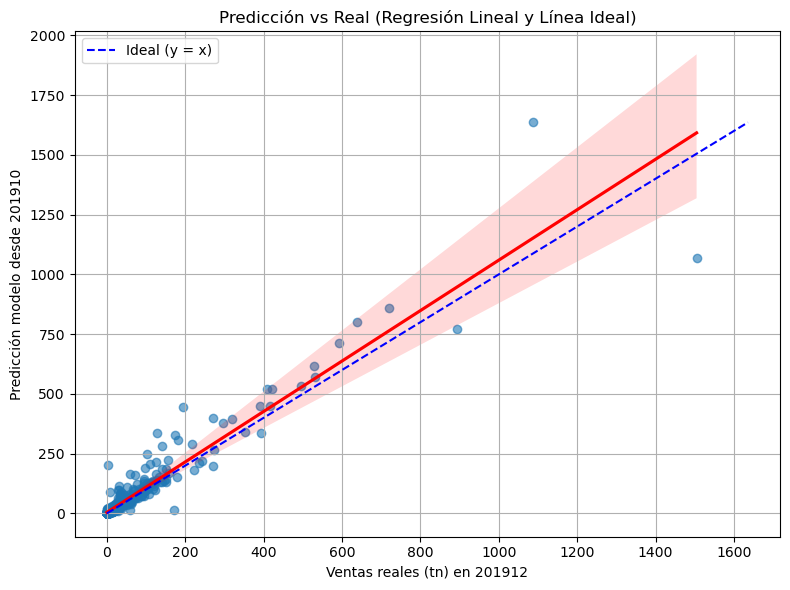

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Cargar predicciones
pred = pd.read_csv("prediccion_tn_t+2_201910.csv")

# Cargar datos reales del periodo 201912
df = pd.read_csv("dataset_limpio.txt", sep="\t")
df['product_id'] = df['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Ventas reales de tn en 201912
real = df[df['periodo'] == 201912][['product_id', 'tn']].copy()
real = real.groupby('product_id')['tn'].sum().reset_index()
real = real.rename(columns={'tn': 'tn_real'})

pred['product_id'] = pred['product_id'].astype(str)
real['product_id'] = real['product_id'].astype(str)
# Unir predicción y realidad
eval_df = pd.merge(pred, real, on='product_id', how='inner')

# Calcular métricas
rmse = np.sqrt(mean_squared_error(eval_df['tn_real'], eval_df['tn_predicha']))
mae = mean_absolute_error(eval_df['tn_real'], eval_df['tn_predicha'])
r2 = r2_score(eval_df['tn_real'], eval_df['tn_predicha'])

print(f"🔍 RMSE: {rmse:.2f}")
print(f"📉 MAE: {mae:.2f}")
print(f"📈 R²: {r2:.4f}")

# Gráfico de dispersión con línea de identidad (y = x)
plt.figure(figsize=(8, 6))
sns.regplot(x='tn_real', y='tn_predicha', data=eval_df, line_kws={"color": "red"}, scatter_kws={"alpha":0.6})
plt.plot([0, eval_df[['tn_real', 'tn_predicha']].values.max()],
         [0, eval_df[['tn_real', 'tn_predicha']].values.max()],
         color='blue', linestyle='--', label='Ideal (y = x)')
plt.xlabel('Ventas reales (tn) en 201912')
plt.ylabel('Predicción modelo desde 201910')
plt.title('Predicción vs Real (Regresión Lineal y Línea Ideal)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 

In [1]:
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Cargar datos
pred = pd.read_csv("prediccion_tn_t+2_201910.csv")
df = pd.read_csv("dataset_limpio.txt", sep="\t")

# Asegurar tipos
pred['product_id'] = pred['product_id'].astype(str)
df['product_id'] = df['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Datos reales de tn en 201912
real = df[df['periodo'] == 201912][['product_id', 'tn']]
real = real.groupby('product_id')['tn'].sum().reset_index()
real = real.rename(columns={'tn': 'tn_real'})
real['product_id'] = real['product_id'].astype(str)

# Merge predicción vs realidad
eval_df = pd.merge(pred, real, on='product_id', how='inner')

# Métricas
rmse = np.sqrt(mean_squared_error(eval_df['tn_real'], eval_df['tn_predicha']))
mae = mean_absolute_error(eval_df['tn_real'], eval_df['tn_predicha'])
r2 = r2_score(eval_df['tn_real'], eval_df['tn_predicha'])

print(f"🔍 RMSE: {rmse:.2f}")
print(f"📉 MAE: {mae:.2f}")
print(f"📈 R²: {r2:.4f}")

# Gráfico interactivo
fig = px.scatter(eval_df,
                 x='tn_real',
                 y='tn_predicha',
                 hover_data=['product_id', 'tn_real', 'tn_predicha'],
                 labels={
                     'tn_real': 'Ventas reales (201912)',
                     'tn_predicha': 'Predicción (desde 201910)'
                 },
                 title='Predicción vs Real con Hover')

# Agregar línea y = x
max_val = max(eval_df['tn_real'].max(), eval_df['tn_predicha'].max())
fig.add_shape(type='line',
              x0=0, y0=0,
              x1=max_val, y1=max_val,
              line=dict(color='blue', dash='dash'),
              name='Ideal')

fig.update_layout(width=800, height=600)
fig.show()


🔍 RMSE: 36.48
📉 MAE: 11.16
📈 R²: 0.8718


In [4]:
import pandas as pd
import numpy as np
import plotly.express as px

def plot_pred_vs_real(
    pred_file,
    real_file,
    modelo="Modelo",
    export_html=False,
    html_path="pred_vs_real.html",
    pred_col_pred="tn_predicha",
    pred_col_id="product_id",
    real_col_real="tn_real",
    real_col_id="product_id"
):
    """
    Grafica predicción vs real usando Plotly y permite exportar a HTML.

    Args:
        pred_file (str): Ruta al archivo CSV con las predicciones.
        real_file (str): Ruta al archivo con las ventas reales.
        modelo (str): Nombre del modelo utilizado (se muestra en el título).
        export_html (bool): Si True, exporta el gráfico a HTML.
        html_path (str): Ruta de salida para el archivo HTML.
        pred_col_pred (str): Columna de predicción en pred_file.
        pred_col_id (str): Columna ID en pred_file.
        real_col_real (str): Columna real en real_file (debe existir o será creada).
        real_col_id (str): Columna ID en real_file.
    """
    # Cargar predicciones
    pred = pd.read_csv(pred_file)
    pred[pred_col_id] = pred[pred_col_id].astype(str)

    # Cargar datos reales (puede ser dataset_limpio.txt)
    if real_file.endswith(".txt"):
        real = pd.read_csv(real_file, sep="\t")
    else:
        real = pd.read_csv(real_file)

    # Asegurar que 'product_id' y 'periodo' existan
    if 'product_id' not in real.columns or 'tn' not in real.columns or 'periodo' not in real.columns:
        raise ValueError("El archivo de datos reales debe contener las columnas: 'product_id', 'tn', y 'periodo'.")

    # Preprocesamiento para dataset_limpio
    real['product_id'] = real['product_id'].astype(str)
    real = real[real['periodo'] == 201912]
    real = real.groupby('product_id')['tn'].sum().reset_index()
    real = real.rename(columns={'tn': real_col_real})
    real[real_col_id] = real[real_col_id].astype(str)

    # Merge
    df = pd.merge(pred, real, left_on=pred_col_id, right_on=real_col_id, how='inner')

    if df.empty:
        print("⚠️ No hay registros coincidentes entre predicción y realidad.")
        return

    # Métricas
    rmse = np.sqrt(((df[pred_col_pred] - df[real_col_real]) ** 2).mean())
    mae = np.abs(df[pred_col_pred] - df[real_col_real]).mean()
    r2 = 1 - ((df[pred_col_pred] - df[real_col_real]) ** 2).sum() / ((df[real_col_real] - df[real_col_real].mean()) ** 2).sum()

    # Gráfico interactivo
    fig = px.scatter(
        df,
        x=real_col_real,
        y=pred_col_pred,
        hover_data=[pred_col_id, real_col_real, pred_col_pred],
        labels={real_col_real: "Ventas reales", pred_col_pred: "Predicción"},
        title=f"Predicción vs Real ({modelo})<br>RMSE={rmse:.2f} | MAE={mae:.2f} | R²={r2:.4f}"
    )

    # Línea ideal
    max_val = max(df[real_col_real].max(), df[pred_col_pred].max())
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=max_val, y1=max_val,
        line=dict(color='blue', dash='dash')
    )
    fig.update_layout(width=800, height=600)

    # Exportar
    if export_html:
        fig.write_html(html_path)
        print(f"✅ Gráfico exportado a {html_path}")

    fig.show()


In [6]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="prediccion_tn_t+2_201910.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM basico con 11 lags tn y 5 lags stock",
    export_html=True,
    html_path="pred_vs_real_tn_t+2.html"
)


✅ Gráfico exportado a pred_vs_real_tn_t+2.html


### FEATURE ENGENIERING

##### Feature fechas

In [9]:
import pandas as pd
import numpy as np

def add_fecha_features(
    df: pd.DataFrame,
    periodo_col: str = "periodo",
    prefix: str = "",
    include_cyclic: bool = True,
    include_periodo_ordinal: bool = True
) -> pd.DataFrame:
    """
    Agrega features de fecha a partir de una columna con formato YYYYMM.

    Args:
        df (pd.DataFrame): Dataset con la columna de periodo.
        periodo_col (str): Nombre de la columna con el periodo en formato YYYYMM.
        prefix (str): Prefijo para agregar a las nuevas columnas. Ej: "f_" → "f_anio".
        include_cyclic (bool): Si True, incluye mes_sin y mes_cos.
        include_periodo_ordinal (bool): Si True, agrega un ranking temporal.

    Returns:
        pd.DataFrame: DataFrame con las nuevas columnas de fecha agregadas.
    """
    df = df.copy()

    # Año y mes
    df[f"{prefix}anio"] = df[periodo_col] // 100
    df[f"{prefix}mes"] = df[periodo_col] % 100

    # Trimestre
    df[f"{prefix}trimestre"] = ((df[f"{prefix}mes"] - 1) // 3 + 1).astype(int)

    # Codificación cíclica mes (seno/coseno)
    if include_cyclic:
        df[f"{prefix}mes_sin"] = np.sin(2 * np.pi * df[f"{prefix}mes"] / 12)
        df[f"{prefix}mes_cos"] = np.cos(2 * np.pi * df[f"{prefix}mes"] / 12)

    # Periodo ordinal (opcional)
    if include_periodo_ordinal:
        df[f"{prefix}periodo_ordinal"] = df[periodo_col].rank(method='dense').astype(int)

    return df



In [7]:
import pandas as pd

df = pd.read_csv("dataset_limpio.txt", sep="\t")
print("🧩 Columnas disponibles:")
print(df.columns.tolist())


🧩 Columnas disponibles:
['periodo', 'customer_id', 'product_id', 'tn', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'CLASE', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5']


In [16]:
import pandas as pd

# Cargar tu dataset original
df = pd.read_csv("dataset_limpio.txt", sep="\t")

# Aplicar la función
df = add_fecha_features(
    df,
    periodo_col="periodo",   # nombre de la columna que contiene YYYYMM
    prefix="f_",             # prefijo para las nuevas columnas
    include_cyclic=True,     # para agregar mes_sin y mes_cos
    include_periodo_ordinal=True  # para agregar un ranking del tiempo
)


In [18]:
#guardamos el dataset enriquecido en formato txt 
df.to_csv("df_feat_fecha.txt", sep="\t", index=False)


#### Delta Lags

In [11]:
def add_delta_lags(df, lag_prefix="tm-", max_lag=11, inplace=False):
    """
    Agrega columnas de delta_lags al DataFrame a partir de columnas de lags ya existentes.

    Args:
        df (pd.DataFrame): Dataset con columnas tipo 'tm-1', 'tm-2', ..., 'tm-max_lag'.
        lag_prefix (str): Prefijo común para las columnas de lags.
        max_lag (int): Número máximo de lags disponibles (por ejemplo, 11 si tenés de tm-0 a tm-11).
        inplace (bool): Si True, modifica el DataFrame original. Si False, devuelve una copia.

    Returns:
        pd.DataFrame: El DataFrame con nuevas columnas delta agregadas (si inplace=False).
    """
    if not inplace:
        df = df.copy()

    for i in range(1, max_lag):
        lag_col_1 = f"{lag_prefix}{i}"
        lag_col_2 = f"{lag_prefix}{i + 1}"
        delta_col = f"delta_lag_{i}"
        if lag_col_1 in df.columns and lag_col_2 in df.columns:
            df[delta_col] = df[lag_col_1] - df[lag_col_2]
        else:
            print(f"⚠️ Columnas faltantes para delta {i}: {lag_col_1}, {lag_col_2} no están en el DataFrame.")

    if not inplace:
        return df


In [23]:
df = pd.read_csv("dataset_limpio.txt", sep="\t")

# Agregar delta lags sin modificar df original
df_with_deltas = add_delta_lags(df, lag_prefix="tm-", max_lag=11)

# O modificar directamente el DataFrame
add_delta_lags(df, lag_prefix="tm-", max_lag=11, inplace=True)


In [24]:
#guardamos el dataset enriquecido en formato txt 
df.to_csv("df_feat_fecha_delta.txt", sep="\t", index=False)

In [31]:
#guardamos el dataset de fecha y delta
df = pd.read_csv("dataset_limpio.txt", sep="\t")
# O modificar directamente el DataFrame
add_delta_lags(df, lag_prefix="tm-", max_lag=11, inplace=True)
# Aplicar la función
df = add_fecha_features(
    df,
    periodo_col="periodo",   # nombre de la columna que contiene YYYYMM
    prefix="f_",             # prefijo para las nuevas columnas
    include_cyclic=True,     # para agregar mes_sin y mes_cos
    include_periodo_ordinal=True  # para agregar un ranking del tiempo
)

#guardamos el dataset enriquecido en formato txt 
df.to_csv("df_feat_fecha_delta.txt", sep="\t", index=False)

In [32]:
print(df.columns.tolist())

['periodo', 'customer_id', 'product_id', 'tn', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'CLASE', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal']


#### rolling means

In [12]:
def add_rolling_means(df, lag_prefix="tm-", lags=11, windows=[3, 6, 12], inplace=False):
    """
    Agrega medias móviles a partir de columnas de lags ya existentes.

    Args:
        df (pd.DataFrame): DataFrame con columnas 'tm-1' a 'tm-N'.
        lag_prefix (str): Prefijo común de los lags.
        lags (int): Número máximo de lags disponibles (e.g., 11 para 'tm-1' a 'tm-11').
        windows (list): Tamaños de ventanas para promedios móviles.
        inplace (bool): Si True, modifica el DataFrame original.

    Returns:
        pd.DataFrame: Con nuevas columnas agregadas si inplace=False.
    """
    if not inplace:
        df = df.copy()

    # Recolectar columnas ordenadas como tm-1, tm-2, ..., tm-N
    lag_cols = [f"{lag_prefix}{i}" for i in range(1, lags + 1)]
    lag_cols = [col for col in lag_cols if col in df.columns]

    for w in windows:
        if w <= len(lag_cols):
            cols = lag_cols[:w]  # usar los w más recientes
            df[f"rolling_mean_{w}"] = df[cols].mean(axis=1)
        else:
            print(f"⚠️ Ventana {w} demasiado grande para los lags disponibles ({len(lag_cols)})")

    if not inplace:
        return df


In [35]:
df = pd.read_csv("dataset_limpio.txt", sep="\t")

# Agregar medias móviles de 3, 6 y 12 periodos
df = add_rolling_means(df, lags=11, windows=[3, 6, 12], inplace=False)
add_delta_lags(df, lag_prefix="tm-", max_lag=11, inplace=True)
# Aplicar la función
df = add_fecha_features(
    df,
    periodo_col="periodo",   # nombre de la columna que contiene YYYYMM
    prefix="f_",             # prefijo para las nuevas columnas
    include_cyclic=True,     # para agregar mes_sin y mes_cos
    include_periodo_ordinal=True  # para agregar un ranking del tiempo
)
#guardamos el dataset enriquecido en formato txt 
df.to_csv("df_feat_fecha_delta_rolling.txt", sep="\t", index=False)

⚠️ Ventana 12 demasiado grande para los lags disponibles (11)


In [ ]:
#guardamos el dataset enriquecido en formato txt 
df.to_csv("df_feat_fecha_delta.txt", sep="\t", index=False)

#### Prophet caracteristicas

seleccionamos los productos a entrenar


In [13]:
import pandas as pd

def obtener_tn_filtrado(
    path_datos="sell-in.txt",
    path_productos_objetivo="product_id_apredecir201912.txt",
    sep="\t",
    min_obs=12
):
    """
    Devuelve las sumas de tn > 0 por product_id y periodo,
    solo para productos que estén en el archivo objetivo
    y tengan al menos `min_obs` observaciones válidas.

    Args:
        path_datos (str): Ruta al archivo de ventas.
        path_productos_objetivo (str): Ruta al archivo de productos objetivo.
        sep (str): Separador del archivo de ventas.
        min_obs (int): Mínimo de observaciones válidas requeridas por producto.

    Returns:
        pd.DataFrame: Columnas ['product_id', 'periodo', 'tn']
    """
    # Cargar datos
    df = pd.read_csv(path_datos, sep=sep)
    productos_obj = pd.read_csv(path_productos_objetivo, sep="\t")

    # Asegurar tipo string para claves
    df['product_id'] = df['product_id'].astype(str)
    productos_obj['product_id'] = productos_obj['product_id'].astype(str)

    # Filtrar solo tn válidas
    df_valid = df[df['tn'].notna() & (df['tn'] > 0)].copy()

    # Filtrar solo productos objetivos
    df_valid = df_valid[df_valid['product_id'].isin(productos_obj['product_id'])]

    # Filtrar por cantidad mínima de observaciones válidas por producto
    counts = df_valid['product_id'].value_counts()
    productos_validos = counts[counts >= min_obs].index
    df_valid = df_valid[df_valid['product_id'].isin(productos_validos)]

    # Agrupar por product_id y periodo sumando tn
    resultado = (
        df_valid
        .groupby(['product_id', 'periodo'], as_index=False)['tn']
        .sum()
    )

    return resultado


In [8]:
df_final = obtener_tn_filtrado()
print(df_final.head())
print(df_final['product_id'].nunique(), "productos finales")
df_final.to_csv("tn_filtrado.txt", sep="\t", index=False)
df_final.to_csv("tn_filtrado.csv", index=False)


  product_id  periodo          tn
0      20001   201701   934.77222
1      20001   201702   798.01620
2      20001   201703  1303.35771
3      20001   201704  1069.96130
4      20001   201705  1502.20132
780 productos finales


entrenamiento de los 780 productos, dura aproxi 2hs 20m 

In [ ]:
import pandas as pd
from neuralprophet import NeuralProphet
from tqdm import tqdm

# -----------------------------
# 1. Cargar y preparar dataset
# -----------------------------
df = pd.read_csv("tn_filtrado.csv")  # Asegurate que este archivo esté en la misma carpeta
df["ds"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# Lista para almacenar resultados
resultados = []

# -----------------------------
# 2. Entrenar modelo por producto
# -----------------------------
for product_id in tqdm(df["product_id"].unique(), desc="Procesando productos"):
    df_prod = df[df["product_id"] == product_id].copy()
    df_prod = df_prod.rename(columns={"tn": "y"})

    model = NeuralProphet(yearly_seasonality=True)
    model.fit(df_prod[["ds", "y"]], freq="MS")

    # Predecir incluyendo la columna 'y' y componentes descompuestos
    forecast = model.predict(df_prod[["ds", "y"]], decompose=True)

    # Validar columnas disponibles
    expected_columns = ['trend', 'trend_rate', 'season_yearly', 'yhat1', 'residual1']
    available_columns = [col for col in expected_columns if col in forecast.columns]

    # Agregar identificador de producto y periodo
    forecast["product_id"] = product_id
    forecast["periodo"] = forecast["ds"].dt.strftime("%Y%m").astype(int)

    # Guardar solo las columnas disponibles + identificadores
    resultados.append(forecast[["product_id", "periodo"] + available_columns])

# -----------------------------
# 3. Concatenar y guardar
# -----------------------------
df_resultado = pd.concat(resultados, ignore_index=True)
df_resultado.to_csv("componentes_neuralprophet.csv", index=False)

# Mostrar primeras filas
df_resultado.head()


#### agregamos Residual1 al dataset de neuralprophet

In [14]:
import pandas as pd

# Cargar el archivo con las predicciones
df_pred = pd.read_csv("componentes_neuralprophet.csv")

# Cargar el archivo original con los datos reales
df_real = pd.read_csv("tn_filtrado.csv")

# Asegurarse de que 'periodo' esté en el mismo formato (int)
df_real["periodo"] = df_real["periodo"].astype(int)

# Unir ambos por product_id y periodo
df = pd.merge(df_pred, df_real, on=["product_id", "periodo"])

# Calcular residual1
df["residual1"] = df["tn"] - df["yhat1"]

# Crear lags
max_lag = 3
df = df.sort_values(["product_id", "periodo"])

for i in range(1, max_lag + 1):
    df[f"residual1_lag{i}"] = df.groupby("product_id")["residual1"].shift(i)

# Guardar el resultado
df.to_csv("componentes_neuralprophet_con_residual.csv", index=False)
df.head()



,product_id,periodo,trend,season_yearly,yhat1,tn,residual1,residual1_lag1,residual1_lag2,residual1_lag3
0,20001,201701,1230.3796,-269.121300,961.25836,934.77222,-26.48614,NaN,NaN,NaN
1,20001,201702,1217.2424,-313.895170,903.34720,798.01620,-105.33100,-26.48614,NaN,NaN
2,20001,201703,1205.3765,141.470640,1346.84720,1303.35771,-43.48949,-105.33100,-26.48614,NaN
3,20001,201704,1202.6208,-0.593033,1202.02780,1069.96130,-132.06650,-43.48949,-105.33100,-26.48614
4,20001,201705,1214.5901,93.016846,1307.60690,1502.20132,194.59442,-132.06650,-43.48949,-105.33100


In [15]:
import pandas as pd

df = pd.read_csv("componentes_neuralprophet_con_residual.csv")
print(df.columns.tolist())



['product_id', 'periodo', 'trend', 'season_yearly', 'yhat1', 'tn', 'residual1', 'residual1_lag1', 'residual1_lag2', 'residual1_lag3']


#### agregamos delta yhat1 y trend

In [11]:
import pandas as pd

df = pd.read_csv("componentes_neuralprophet_con_residual.csv")
df = df.sort_values(["product_id", "periodo"])

# Lags
df["yhat1_lag1"] = df.groupby("product_id")["yhat1"].shift(1)
df["trend_lag1"] = df.groupby("product_id")["trend"].shift(1)

# Deltas
df["delta_yhat1"] = df["yhat1"] - df["yhat1_lag1"]
df["delta_trend"] = df["trend"] - df["trend_lag1"]

# Guardar
df.to_csv("componentes_neuralprophet_con_deltas.csv", index=False)


#### Tiempo de vida de clientes

In [ ]:
# Asegúrate de que los campos estén en formato correcto

df = pd.read_csv("dataset_limpio2.txt", sep="\t")
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Crear una tabla con los periodos únicos en los que cada cliente estuvo activo
historial_cliente = df[df['tn'] > 0].groupby('customer_id')['periodo'].unique().to_dict()

# Función para contar cuántos meses estuvo activo hasta el periodo actual
def calcular_meses_activos(row):
    cliente = row['customer_id']
    periodo_actual = row['periodo']
    if cliente in historial_cliente:
        return sum(p <= periodo_actual for p in historial_cliente[cliente])
    else:
        return 0


#### IPM

In [33]:
import pandas as pd

# -----------------------------
# 1. Cargar dataset principal
# -----------------------------
df = pd.read_csv("dataset_limpio.txt", sep="\t")
df['periodo'] = df['periodo'].astype(int)

# -----------------------------
# 2. Mapeo ipim_categoria por cat1/cat2
# -----------------------------
mapeo_ipim = {
    ('FOODS', None): '15_alimentos_y_bebidas',
    ('FOODS', 'SOPAS Y CALDOS'): '1549_otros_productos_alimenticios_n.c.e.p.',
    ('FOODS', 'ADEREZOS'): '1544_productos_farinaceos',
    ('FOODS', 'TE'): '1544_productos_farinaceos',
    ('FOODS', 'Galletitas'): '1544_productos_farinaceos',
    ('FOODS', 'Pastas'): '1531_harinas',
    ('REF', None): '1554_bebidas_no_alcoholicas',
    ('HC', None): '2424_jabones_y_detergentes',
    ('HC', 'VAJILLA'): '2424_jabones_y_detergentes',
    ('HC', 'ROPA LAVADO'): '2424_jabones_y_detergentes',
    ('HC', 'ROPA MANCHAS'): '2424_jabones_y_detergentes',
    ('HC', 'HOGAR'): '2424_jabones_y_detergentes',
    ('PC', None): '2424_jabones_y_detergentes',
    ('PC', 'CABELLO'): '2424_jabones_y_detergentes',
    ('PC', 'DEOS'): '2424_jabones_y_detergentes',
    ('PC', 'PIEL1'): '2424_jabones_y_detergentes',
    ('PC', 'PIEL2'): '2424_jabones_y_detergentes'
}

def asignar_ipim_categoria(cat1, cat2):
    return mapeo_ipim.get((cat1, cat2), 'sin_categoria')

df['ipim_categoria'] = df.apply(lambda x: asignar_ipim_categoria(x['cat1'], x['cat2']), axis=1)

# -----------------------------
# 3. Cargar IPIM
# -----------------------------
ipim = pd.read_csv("indice_ipim.csv", sep=";")

# Convertir a formato yyyymm
ipim['periodo'] = pd.to_datetime(ipim['periodo'], format="%Y-%m-%d")
ipim['periodo'] = ipim['periodo'].dt.strftime("%Y%m").astype(int)

# Renombrar columnas
ipim = ipim.rename(columns={
    'nivel_general_aperturas': 'ipim_categoria',
    'indice_ipim': 'ipim_valor'
})

# Ordenar y generar lags
ipim = ipim.sort_values(by=['ipim_categoria', 'periodo'])

def generar_lags(grupo):
    grupo['ipim_tm-1'] = grupo['ipim_valor'].shift(1)
    grupo['ipim_tm-2'] = grupo['ipim_valor'].shift(2)
    grupo['delta_ipim_1m'] = grupo['ipim_valor'] - grupo['ipim_tm-1']
    grupo['delta_ipim_2m'] = grupo['ipim_valor'] - grupo['ipim_tm-2']
    grupo['pct_ipim_1m'] = grupo['delta_ipim_1m'] / grupo['ipim_tm-1']
    grupo['pct_ipim_2m'] = grupo['delta_ipim_2m'] / grupo['ipim_tm-2']
    return grupo

ipim_lags = ipim.groupby('ipim_categoria').apply(generar_lags).drop(columns=['ipim_valor'])
ipim_lags = ipim_lags.reset_index(drop=True)

# -----------------------------
# 4. Merge con dataset principal
# -----------------------------
df = df.merge(ipim_lags, on=['ipim_categoria', 'periodo'], how='left')

# -----------------------------
# 5. Eliminar filas con valores faltantes de IPIM
# -----------------------------
# Solo asegurate de que el target esté presente (si estás entrenando)
# Si estás generando el dataset para predicción, podés incluso omitir este paso
#if 'tn' in df.columns:
#    df = df[df['tn'].notna()]
# -----------------------------
# 5.1 Agregar rolling averages y derivados de tn/stock
# -----------------------------
print("📦 Agregando features: avg_tn_3m, delta_tn, avg_stock_3m, stock_to_tn_ratio...")

# Promedio móvil de tn de los últimos 3 meses
df['avg_tn_3m'] = df[['tn', 'tm-1', 'tm-2']].mean(axis=1)

# Cambios de tn
df['delta_tn_1'] = df['tn'] - df['tm-1']
df['delta_tn_2'] = df['tn'] - df['tm-2']

# Promedio móvil de stock y ratio stock/tn si existen
if all(col in df.columns for col in ['stock_tm-0', 'stock_tm-1', 'stock_tm-2']):
    df['avg_stock_3m'] = df[['stock_tm-0', 'stock_tm-1', 'stock_tm-2']].mean(axis=1)
    df['stock_to_tn_ratio'] = df['stock_tm-0'] / (df['tn'] + 1e-6)  # evitar división por 0
else:
    print("⚠️ Algunas columnas de stock no están presentes. No se agregan avg_stock_3m ni stock_to_tn_ratio.")


# -----------------------------
# 6. Guardar dataset final
# -----------------------------
df.to_csv("dataset_limpio2.txt", sep="\t", index=False)
print("✅ Dataset final generado: dataset_limpio2.txt")


C:\Users\marco\AppData\Local\Temp\ipykernel_15256\3278353202.py:64: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



📦 Agregando features: avg_tn_3m, delta_tn, avg_stock_3m, stock_to_tn_ratio...
✅ Dataset final generado: dataset_limpio2.txt


#### Clusterización de productos por comportamiento

In [12]:
from sklearn.cluster import KMeans

# Agrupar por producto
agrupado = df.groupby("product_id").agg({
    "residual1": "std",
    "yhat1": "mean",
    "tn": "sum"
}).rename(columns={
    "residual1": "residual1_std",
    "yhat1": "media_yhat1",
    "tn": "volumen_total"
})

# Clusterizar
kmeans = KMeans(n_clusters=4, random_state=42)
agrupado["cluster"] = kmeans.fit_predict(agrupado)

# Unir al dataset original
df = df.merge(agrupado["cluster"], on="product_id", how="left")

# Guardar final
df.to_csv("componentes_neuralprophet_full.csv", index=False)


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



creamos el dataset con fecha y neural prophet full

In [ ]:
import pandas as pd

# Cargar ambos datasets
df_base = pd.read_csv("dataset_limpio.csv")
df_comp = pd.read_csv("componentes_neuralprophet_full.csv")

# Eliminar la columna 'tn' del de componentes
df_comp = df_comp.drop(columns=["tn"])

# Merge por product_id y periodo
df = pd.merge(df_base, df_comp, on=["product_id", "periodo"], how="left")
#agregamos la funcion de fecha
df = add_fecha_features(
    df,
    periodo_col="periodo",   # nombre de la columna que contiene YYYYMM
    prefix="f_",             # prefijo para las nuevas columnas
    include_cyclic=True,     # para agregar mes_sin y mes_cos
    include_periodo_ordinal=True  # para agregar un ranking del tiempo
)
#guardamos el dataset enriquecido en formato txt 
df.to_csv("dataset_limpio_con_componentes.txt", sep="\t", index=False)

#### Superdatset con features (armado)

In [14]:
import pandas as pd

##### NEURALPROPHET COMPONENTES #####
# Cargar ambos datasets
df_base = pd.read_csv("dataset_limpio2.txt", sep="\t") #### BASICO CON IPIM
df_comp = pd.read_csv("componentes_neuralprophet_full.csv")
# Eliminar la columna 'tn' del de componentes
df_comp = df_comp.drop(columns=["tn"])
# Merge por product_id y periodo
df = pd.merge(df_base, df_comp, on=["product_id", "periodo"], how="left")
#agregamos la funcion de fecha
##### AGREGAR FECHA #####
df = add_fecha_features(
    df,
    periodo_col="periodo",   # nombre de la columna que contiene YYYYMM
    prefix="f_",             # prefijo para las nuevas columnas
    include_cyclic=True,     # para agregar mes_sin y mes_cos
    include_periodo_ordinal=True  # para agregar un ranking del tiempo
)
##### AGREGAR LAGS Y ROLLING MEANS #####
df = add_delta_lags(df, lag_prefix="tm-", max_lag=11)
df = add_rolling_means(df, lags=11, windows=[3, 6, 11], inplace=False)
##### AGREGAMOS TIEMPO DE VIDA DEL CLIENTE #####
# Paso 1: Filtrar ventas reales
ventas_reales = df[df['tn'] > 0].copy()
ventas_reales['compra_real'] = 1

# Paso 2: Ordenar para aplicar cumsum correctamente
ventas_reales = ventas_reales.sort_values(['customer_id', 'periodo'])

# Paso 3: Calcular acumulado por cliente
ventas_reales['cliente_meses_activo_hasta_periodo'] = ventas_reales.groupby('customer_id')['compra_real'].cumsum()

# 🔧 Paso 4: Agrupar por customer_id y periodo para garantizar unicidad
valores_unicos = ventas_reales.groupby(['customer_id', 'periodo'])['cliente_meses_activo_hasta_periodo'].max()

# Paso 5: Mapear de forma segura al df original
df_index = df.set_index(['customer_id', 'periodo']).index
df['cliente_meses_activo_hasta_periodo'] = df_index.map(valores_unicos).fillna(0).astype(int)



In [20]:
#vemos los headers
print(df.columns.tolist())


['periodo', 'customer_id', 'product_id', 'tn', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'CLASE', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'ipim_categoria', 'ipim_tm-1', 'ipim_tm-2', 'delta_ipim_1m', 'delta_ipim_2m', 'pct_ipim_1m', 'pct_ipim_2m', 'avg_tn_3m', 'delta_tn_1', 'delta_tn_2', 'avg_stock_3m', 'stock_to_tn_ratio', 'trend', 'season_yearly', 'yhat1', 'residual1', 'residual1_lag1', 'residual1_lag2', 'residual1_lag3', 'yhat1_lag1', 'trend_lag1', 'delta_yhat1', 'delta_trend', 'cluster', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_11', 'cliente_meses_activo_hasta_periodo']


#### Modelo basico + fechas

In [20]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201910  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
df = pd.read_csv("df_feat_fecha.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")


C:\Users\marco\AppData\Local\Temp\ipykernel_19940\2599157787.py:25: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand']

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.336922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6176
[LightGBM] [Info] Number of data poi

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\2599157787.py:99: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [21]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="prediccion_tn_t+2_201910.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM basico + fechas",
    export_html=True,
    html_path="Modelo_basico_y_fechas.html"
)

✅ Gráfico exportado a Modelo_basico_y_fechas.html


#### Modelo Basico + lags

In [ ]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201910  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
df = pd.read_csv("df_feat_fecha_delta.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\3905582959.py:25: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand']

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.339915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\marco\AppData\Local\Temp\ipykernel_19940\3905582959.py:99: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [27]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="prediccion_tn_t+2_201910.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM basico + fechas + delta lags",
    export_html=True,
    html_path="Modelo_basico_y_fechas_delta_lags.html"
)

✅ Gráfico exportado a Modelo_basico_y_fechas_delta_lags.html


#### Modelo Basico + fechas + delta lags

In [33]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201910  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
df = pd.read_csv("df_feat_fecha_delta.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\3905582959.py:25: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand']

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.414572 seconds.
You can set `force_row_wise=true` to remo

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\3905582959.py:99: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [34]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="prediccion_tn_t+2_201910.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM basico + fechas + delta lags",
    export_html=True,
    html_path="Modelo_basico_y_fechas_delta_lags.html"
)

✅ Gráfico exportado a Modelo_basico_y_fechas_delta_lags.html


#### Modelo basico + fechas + delta lags + rollings means

In [36]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201910  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
df = pd.read_csv("df_feat_fecha_delta_rolling.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\1951640742.py:25: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'rolling_mean_3', 'rolling_mean_6', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand']

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.377354 seconds.
You c

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\1951640742.py:99: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [37]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="prediccion_tn_t+2_201910.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM basico + fechas + delta lags + rolling",
    export_html=True,
    html_path="Modelo_basico_fechas_delta_lags_rolling.html"
)

✅ Gráfico exportado a Modelo_basico_fechas_delta_lags_rolling.html


#### Modelo basico + fecha + neuralprophet

In [3]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201910  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_limpio_con_componentes.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

C:\Users\marco\AppData\Local\Temp\ipykernel_15256\2153602168.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]


🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'trend', 'season_yearly', 'yhat1', 'residual1', 'residual1_lag1', 'residual1_lag2', 'residual1_lag3', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand']

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.379644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

C:\Users\marco\AppData\Local\Temp\ipykernel_15256\2153602168.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()


In [4]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="prediccion_tn_t+2_201910.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM basico + fechas + neuralprophet",
    export_html=True,
    html_path="Modelo_basico_fechas_neuralprophet.html"
)

✅ Gráfico exportado a Modelo_basico_fechas_neuralprophet.html


#### modelo basico + fechas + neuralprophet + cluster por producto  

In [21]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201912  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
#df = pd.read_csv("dataset_limpio_con_componentes.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3','ipim_categoria']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1, max_bin=1024)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'ipim_categoria', 'ipim_tm-1', 'ipim_tm-2', 'delta_ipim_1m', 'delta_ipim_2m', 'pct_ipim_1m', 'pct_ipim_2m', 'avg_tn_3m', 'delta_tn_1', 'delta_tn_2', 'avg_stock_3m', 'stock_to_tn_ratio', 'trend', 'season_yearly', 'yhat1', 'residual1', 'residual1_lag1', 'residual1_lag2', 'residual1_lag3', 'yhat1_lag1', 'trend_lag1', 'delta_yhat1', 'delta_trend', 'cluster', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_11', 'cliente_meses_activo_hasta_periodo']
🏷️  Categóricas para LGBM: ['customer_id', 

c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


✅ Entrenamiento completado.

📊 RMSE por fold (CV 5-fold): [0.95359845 0.95524715 0.9955482  0.97969331 0.98459449]
📉 Promedio RMSE: 0.9737

🔮 Generando predicciones para el periodo 201912...

✅ Archivo generado: prediccion_tn_t+2_201912.csv con 780 productos.


In [15]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="prediccion_tn_t+2_201910.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM basico + fechas + neuralprophet + lags + cluster",
    export_html=True,
    html_path="Modelo_basico_fechas_neuralprophet_lags_cluster.html"
)

✅ Gráfico exportado a Modelo_basico_fechas_neuralprophet_lags_cluster.html


#### Modelo basico + fecha + neural +lags

In [9]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201910  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
#df = pd.read_csv("dataset_limpio_con_componentes.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

C:\Users\marco\AppData\Local\Temp\ipykernel_15256\4007412446.py:25: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'trend', 'season_yearly', 'yhat1', 'residual1', 'residual1_lag1', 'residual1_lag2', 'residual1_lag3', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand']

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise mu

C:\Users\marco\AppData\Local\Temp\ipykernel_15256\4007412446.py:99: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [10]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="prediccion_tn_t+2_201910.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM basico + fechas + neuralprophet + lags",
    export_html=True,
    html_path="Modelo_basico_fechas_neuralprophet_lags.html"
)

✅ Gráfico exportado a Modelo_basico_fechas_neuralprophet_lags.html


✅ Opción 1: Ensamble por product_id (switch explícito)

In [20]:

# Cargar ambas predicciones
df_basico = pd.read_csv("predicciones_modelo_basico.csv").rename(columns={"tn_predicha": "pred_basico"})
df_neural = pd.read_csv("componentes_adicionales.csv").rename(columns={"tn_predicha": "pred_neural"})

# Merge por product_id
df = pd.merge(df_basico, df_neural, on="product_id", how="inner")

# Lista de productos donde el modelo básico es mejor
productos_basico = [20003, 20004, 20005, 20010]

# Ensamble condicional
df["tn_predicha"] = df.apply(
    lambda row: row["pred_basico"] if row["product_id"] in productos_basico else row["pred_neural"], axis=1
)

# Guardar archivo ensamblado
df[["product_id", "tn_predicha"]].to_csv("predicciones_ensambladas.csv", index=False)


In [21]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="predicciones_ensambladas.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM ensamblado",
    export_html=True,
    html_path="Modelo_predicciones_ensambladas.html"
)

✅ Gráfico exportado a Modelo_predicciones_ensambladas.html


✅ Script de ensamblado promedio (Opción 2)

In [22]:
import pandas as pd

# Cargar las predicciones de ambos modelos
df_basico = pd.read_csv("predicciones_modelo_basico.csv").rename(columns={"tn_predicha": "pred_basico"})
df_neural = pd.read_csv("componentes_adicionales.csv").rename(columns={"tn_predicha": "pred_neural"})

# Unir por product_id (y periodo si existiera)
df = pd.merge(df_basico, df_neural, on="product_id", how="inner")

# Ensamble promedio simple
df["tn_predicha"] = 0.5 * df["pred_basico"] + 0.5 * df["pred_neural"]

# Guardar la salida final
df[["product_id", "tn_predicha"]].to_csv("predicciones_ensambladas2.csv", index=False)

print("Archivo generado: predicciones_ensambladas2.csv")


Archivo generado: predicciones_ensambladas2.csv


In [23]:
#usamos la funcion para graficar
plot_pred_vs_real(
    pred_file="predicciones_ensambladas2.csv",
    real_file="dataset_limpio.txt",
    modelo="Modelo LGBM ensamblado 2",
    export_html=True,
    html_path="Modelo_predicciones_ensambladas2.html"
)

✅ Gráfico exportado a Modelo_predicciones_ensambladas2.html


#### Modelo basico con nuevos parametros de entrenamiento mejorado

In [7]:
# Entrenamiento, Validación y Predicción configurables con mejoras sugeridas
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧹 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201912

# ----------------------------
# 2. Cargar datasets
# ----------------------------
#df = pd.read_csv("dataset_limpio_con_componentes.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Pesos para ponderar por tn
# ----------------------------
sample_weight = train_df['tn'] / train_df['tn'].mean()

# ----------------------------
# 7. Split para early stopping
# ----------------------------
X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
    train_df[features],
    train_df['CLASE'],
    sample_weight,
    test_size=0.2,
    random_state=42
)

# ----------------------------
# 8. Entrenamiento con mejoras
# ----------------------------
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_bin=255,
    random_state=42,
    n_jobs=-1
)

print("\n🚀 Entrenando el modelo...")
model.fit(
    X_train, y_train,
    sample_weight=sw_train,
    eval_set=[(X_val, y_val)],
    eval_sample_weight=[sw_val],
    early_stopping_rounds=50,
    categorical_feature=lgbm_cat_features,
    verbose=100
)
print("✅ Entrenamiento completado.")

# ----------------------------
# 9. Validación cruzada (sin early stopping)
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)
print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 10. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 11. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")


🧹 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'ipim_categoria', 'ipim_tm-1', 'ipim_tm-2', 'delta_ipim_1m', 'delta_ipim_2m', 'pct_ipim_1m', 'pct_ipim_2m', 'avg_tn_3m', 'delta_tn_1', 'delta_tn_2', 'avg_stock_3m', 'stock_to_tn_ratio', 'trend', 'season_yearly', 'yhat1', 'residual1', 'residual1_lag1', 'residual1_lag2', 'residual1_lag3', 'yhat1_lag1', 'trend_lag1', 'delta_yhat1', 'delta_trend', 'cluster', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_11']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 

c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lig

[100]	valid_0's l2: 449.997
[200]	valid_0's l2: 437.938
[300]	valid_0's l2: 432.221
[400]	valid_0's l2: 426.698
[500]	valid_0's l2: 423.925
[600]	valid_0's l2: 420.714
[700]	valid_0's l2: 419.164
✅ Entrenamiento completado.

📊 RMSE por fold (CV 5-fold): [0.95277423 0.96831306 0.99953516 0.97752459 0.9899767 ]
📉 Promedio RMSE: 0.9776

🔮 Generando predicciones para el periodo 201912...

✅ Archivo generado: prediccion_tn_t+2_201912.csv con 780 productos.


#### Modelo full dataset + opciones de hiperparametros opcion2 variando max bin

In [9]:
# 🧠 LGBM con mejoras: log-transformación, sample_weight y validación temporal

import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 1. Configuración
# ----------------------------
periodo_a_predecir = 201912
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")
#df = pd.read_csv("dataset_limpio_con_componentes.txt", sep="\t")

# ----------------------------
# 2. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3','ipim_categoria']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 3. Features
# ----------------------------
target_col = 'CLASE'
drop_cols = ['tm-0', 'tn']
exclude = set([target_col, 'tn', 'tm-0', 'periodo']).union(set(drop_cols))
features = [c for c in df.columns if c not in exclude]
lgbm_cat_features = [c for c in features if df[c].dtype.name == 'category']

print("🧩 Features seleccionadas:", features)
print("🏷️  Categóricas:", lgbm_cat_features)

# ----------------------------
# 4. Separar datos
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df[target_col].notna()].copy()

# Transformación logarítmica (log1p evita log(0))
train_df["CLASE_LOG"] = np.log1p(train_df[target_col])

# Peso proporcional a tn
train_df["sample_weight"] = train_df["tn"]

# ----------------------------
# 5. Entrenamiento y validación temporal
# ----------------------------
print("\n🚀 Entrenando con validación temporal (TimeSeriesSplit)...")
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_df), 1):
    X_train = train_df.iloc[train_idx][features]
    y_train = train_df.iloc[train_idx]["CLASE_LOG"]
    w_train = train_df.iloc[train_idx]["sample_weight"]
    
    X_val = train_df.iloc[val_idx][features]
    y_val = train_df.iloc[val_idx][target_col]
    
    model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1,max_bin=512)
    model.fit(X_train, y_train, sample_weight=w_train, categorical_feature=lgbm_cat_features)
    
    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log)  # inversa de log1p

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    print(f"🌀 Fold {fold} - RMSE: {rmse:.4f}")

print(f"\n📉 Promedio RMSE: {np.mean(rmse_scores):.4f}")

# ----------------------------
# 6. Entrenamiento final + predicción
# ----------------------------
print("\n🔄 Entrenamiento final con todo el set y predicción para periodo objetivo...")

model_final = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
model_final.fit(train_df[features], train_df["CLASE_LOG"],
                sample_weight=train_df["sample_weight"],
                categorical_feature=lgbm_cat_features)

if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo.")
    predicciones = pd.DataFrame(columns=["product_id", "tn_predicha"])
else:
    pred_df["tn_predicha"] = np.expm1(model_final.predict(pred_df[features]))
    predicciones = pred_df.groupby("product_id")["tn_predicha"].sum().reset_index()

# ----------------------------
# 7. Exportar
# ----------------------------
resultado = pd.merge(productos_objetivo, predicciones, on="product_id", how="left")
resultado["tn_predicha"] = resultado["tn_predicha"].fillna(0)
resultado = resultado.sort_values(by="product_id")
resultado.to_csv(f"prediccion_tn_t+2_{periodo_a_predecir}.csv", index=False)

print(f"\n✅ Archivo generado: prediccion_tn_t+2_{periodo_a_predecir}.csv")


🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'ipim_categoria', 'ipim_tm-1', 'ipim_tm-2', 'delta_ipim_1m', 'delta_ipim_2m', 'pct_ipim_1m', 'pct_ipim_2m', 'avg_tn_3m', 'delta_tn_1', 'delta_tn_2', 'avg_stock_3m', 'stock_to_tn_ratio', 'trend', 'season_yearly', 'yhat1', 'residual1', 'residual1_lag1', 'residual1_lag2', 'residual1_lag3', 'yhat1_lag1', 'trend_lag1', 'delta_yhat1', 'delta_trend', 'cluster', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_11']
🏷️  Categóricas: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand', '

c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


🌀 Fold 1 - RMSE: 0.5256


c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


🌀 Fold 2 - RMSE: 0.2063


c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


🌀 Fold 3 - RMSE: 0.1571


c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


🌀 Fold 4 - RMSE: 0.0912


c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


🌀 Fold 5 - RMSE: 0.0734

📉 Promedio RMSE: 0.2107

🔄 Entrenamiento final con todo el set y predicción para periodo objetivo...


c:\Users\marco\anaconda3\envs\autogluon_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')



✅ Archivo generado: prediccion_tn_t+2_201912.csv


#### Modelo full features + samplew weith

In [15]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201912  # último periodo con clase conocida (CLASE = tn en 201912)

# ----------------------------
# 2. Cargar datasets
# ----------------------------
#df = pd.read_csv("dataset_limpio_con_componentes.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3','ipim_categoria']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 🏋️‍♂️ Asignar sample_weight logarítmico
# ----------------------------
train_df['sample_weight'] = train_df['tn']


# ----------------------------
# 6. Optimización Bayesiana con Optuna
# ----------------------------
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Hiperparámetros a optimizar
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'max_bin': 1024,
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
        
    }
    model = LGBMRegressor(**param)

    # Validación cruzada manual para pasar sample_weight
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list = []
    for train_idx, valid_idx in kf.split(train_df):
        X_train, X_valid = train_df.iloc[train_idx][features], train_df.iloc[valid_idx][features]
        y_train, y_valid = train_df.iloc[train_idx]['CLASE'], train_df.iloc[valid_idx]['CLASE']
        sw_train = train_df.iloc[train_idx]['sample_weight']
        model.fit(X_train, y_train,
                  sample_weight=sw_train,
                  categorical_feature=lgbm_cat_features)
        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        rmse_list.append(rmse)
    return np.mean(rmse_list)

# Crear y ejecutar el estudio
print("\n🔎 Iniciando optimización bayesiana de hiperparámetros (Optuna)...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # Aumenta n_trials para mayor precisión

print("\n🎯 Mejores hiperparámetros encontrados:", study.best_params)
print(f"📉 Mejor RMSE promedio CV: {study.best_value:.4f}")

# Entrenar modelo final con mejores hiperparámetros
best_params = study.best_params
best_params.update({'random_state': 42, 'n_jobs': -1, 'max_bin': 1024})
model = LGBMRegressor(**best_params)
model.fit(
    train_df[features],
    train_df['CLASE'],
    sample_weight=train_df['sample_weight'],
    categorical_feature=lgbm_cat_features
)
print("✅ Entrenamiento completado con hiperparámetros óptimos.")


# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

C:\Users\marco\AppData\Local\Temp\ipykernel_34476\3971364426.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]


🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'ipim_categoria', 'ipim_tm-1', 'ipim_tm-2', 'delta_ipim_1m', 'delta_ipim_2m', 'pct_ipim_1m', 'pct_ipim_2m', 'avg_tn_3m', 'delta_tn_1', 'delta_tn_2', 'avg_stock_3m', 'stock_to_tn_ratio', 'trend', 'season_yearly', 'yhat1', 'residual1', 'residual1_lag1', 'residual1_lag2', 'residual1_lag3', 'yhat1_lag1', 'trend_lag1', 'delta_yhat1', 'delta_trend', 'cluster', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_11', 'cliente_meses_activo_hasta_periodo']
🏷️  Categóricas para LGBM: ['customer_id', 

c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-24 20:21:02,748] A new study created in memory with name: no-name-30991098-2963-4498-9a20-c08ab4179f9c



🔎 Iniciando optimización bayesiana de hiperparámetros (Optuna)...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.385435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the

[I 2025-06-24 20:28:42,971] Trial 0 finished with value: 1.01344610289761 and parameters: {'n_estimators': 700, 'learning_rate': 0.07179863290797263, 'max_depth': 9, 'num_leaves': 77, 'min_child_samples': 8, 'subsample': 0.8072817686645728, 'colsample_bytree': 0.7196980267261119, 'reg_alpha': 0.35304283210018583, 'reg_lambda': 0.8484265407151242}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.313396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325561 seconds.
You can set `force_row_w

[I 2025-06-24 20:35:08,047] Trial 1 finished with value: 1.0303744487170419 and parameters: {'n_estimators': 665, 'learning_rate': 0.04273292536669253, 'max_depth': 13, 'num_leaves': 44, 'min_child_samples': 9, 'subsample': 0.5267052543740491, 'colsample_bytree': 0.7882364956655801, 'reg_alpha': 0.5787917304655782, 'reg_lambda': 0.7629240376962751}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.308545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.307788 seconds.
You can set `force_row_w

[I 2025-06-24 20:38:53,617] Trial 2 finished with value: 1.382610019739444 and parameters: {'n_estimators': 189, 'learning_rate': 0.019026705364015045, 'max_depth': 8, 'num_leaves': 80, 'min_child_samples': 6, 'subsample': 0.8503788043342273, 'colsample_bytree': 0.5938776834381138, 'reg_alpha': 0.9469164384323766, 'reg_lambda': 0.7252088276095605}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.276458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.280468 seconds.
You can set `force_row_w

[I 2025-06-24 20:48:08,040] Trial 3 finished with value: 1.0480448218275131 and parameters: {'n_estimators': 554, 'learning_rate': 0.155229743503066, 'max_depth': 16, 'num_leaves': 55, 'min_child_samples': 9, 'subsample': 0.6974406103987035, 'colsample_bytree': 0.5037172863762751, 'reg_alpha': 0.47143921902563035, 'reg_lambda': 0.09295942580899641}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.347312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.369808 seconds.
You can set `force_row_w

[I 2025-06-24 20:54:51,103] Trial 4 finished with value: 1.0752551950452447 and parameters: {'n_estimators': 560, 'learning_rate': 0.23908980184513368, 'max_depth': 14, 'num_leaves': 101, 'min_child_samples': 4, 'subsample': 0.790295559401043, 'colsample_bytree': 0.9785069744693362, 'reg_alpha': 0.1942733063309503, 'reg_lambda': 0.9231127951737323}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.331299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.339111 seconds.
You can set `force_row_w

[I 2025-06-24 21:05:08,360] Trial 5 finished with value: 1.0216506636894223 and parameters: {'n_estimators': 874, 'learning_rate': 0.012197168366828525, 'max_depth': 10, 'num_leaves': 107, 'min_child_samples': 5, 'subsample': 0.7796153962610626, 'colsample_bytree': 0.731231356816652, 'reg_alpha': 0.6642526689867744, 'reg_lambda': 0.03061768117378827}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.342803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.339243 seconds.
You can set `force_row_w

[I 2025-06-24 21:09:09,322] Trial 6 finished with value: 1.0186436394448883 and parameters: {'n_estimators': 268, 'learning_rate': 0.04813269674980639, 'max_depth': 18, 'num_leaves': 120, 'min_child_samples': 1, 'subsample': 0.5871122020873283, 'colsample_bytree': 0.8197087916915309, 'reg_alpha': 0.09558018303711846, 'reg_lambda': 0.007307563462932043}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.378714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332232 seconds.
You can set `force_row_w

[I 2025-06-24 21:11:46,911] Trial 7 finished with value: 1.0520939975201355 and parameters: {'n_estimators': 167, 'learning_rate': 0.05193851928541307, 'max_depth': 16, 'num_leaves': 79, 'min_child_samples': 6, 'subsample': 0.9971857997425024, 'colsample_bytree': 0.7670052015591116, 'reg_alpha': 0.08595846705279686, 'reg_lambda': 0.19867422363490383}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.293949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-06-24 21:26:01,358] Trial 8 finished with value: 1.3213681599946707 and parameters: {'n_estimators': 891, 'learning_rate': 0.012517069635339318, 'max_depth': 3, 'num_leaves': 97, 'min_child_samples': 1, 'subsample': 0.6296061318446419, 'colsample_bytree': 0.545134174622254, 'reg_alpha': 0.051443403170115864, 'reg_lambda': 0.6884211003626549}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.354010 seconds.
You can set `force_row_w

[I 2025-06-24 21:29:02,264] Trial 9 finished with value: 1.0465539437525997 and parameters: {'n_estimators': 219, 'learning_rate': 0.06567278309339054, 'max_depth': 17, 'num_leaves': 61, 'min_child_samples': 4, 'subsample': 0.5332620614768404, 'colsample_bytree': 0.9017778757008881, 'reg_alpha': 0.6496354756950005, 'reg_lambda': 0.13903831046278725}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.347443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.357467 seconds.
You can set `force_row_w

[I 2025-06-24 21:34:57,476] Trial 10 finished with value: 1.1131163923486405 and parameters: {'n_estimators': 735, 'learning_rate': 0.10861143689041343, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 10, 'subsample': 0.9025987844628768, 'colsample_bytree': 0.6668714714270018, 'reg_alpha': 0.35172582487171206, 'reg_lambda': 0.445540016725888}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.352971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338003 seconds.
You can set `force_row_w

[I 2025-06-24 21:40:02,041] Trial 11 finished with value: 1.0217358338180746 and parameters: {'n_estimators': 368, 'learning_rate': 0.029967404398646553, 'max_depth': 20, 'num_leaves': 127, 'min_child_samples': 1, 'subsample': 0.6592595627687565, 'colsample_bytree': 0.8606457861935427, 'reg_alpha': 0.2707884741394023, 'reg_lambda': 0.3943222400402596}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.372974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332427 seconds.
You can set `force_row_w

[I 2025-06-25 01:34:45,798] Trial 12 finished with value: 1.021322860411567 and parameters: {'n_estimators': 381, 'learning_rate': 0.09914860336665429, 'max_depth': 20, 'num_leaves': 122, 'min_child_samples': 8, 'subsample': 0.5921249423754753, 'colsample_bytree': 0.6565553558242823, 'reg_alpha': 0.38067398719228934, 'reg_lambda': 0.9749785904259264}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.296368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.331514 seconds.
You can set `force_row_w

[I 2025-06-25 01:38:32,035] Trial 13 finished with value: 1.0842322638489708 and parameters: {'n_estimators': 374, 'learning_rate': 0.02843568365764171, 'max_depth': 11, 'num_leaves': 32, 'min_child_samples': 7, 'subsample': 0.7204927684764871, 'colsample_bytree': 0.8521085505833041, 'reg_alpha': 0.19575120904408028, 'reg_lambda': 0.5730241845811592}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.326709 seconds.
You can set `force_row_w

[I 2025-06-25 01:46:31,364] Trial 14 finished with value: 1.0231225160995767 and parameters: {'n_estimators': 767, 'learning_rate': 0.07888134714192992, 'max_depth': 8, 'num_leaves': 81, 'min_child_samples': 3, 'subsample': 0.8661660393664967, 'colsample_bytree': 0.7063580638055255, 'reg_alpha': 0.7902948407064498, 'reg_lambda': 0.3384942670909548}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-06-25 01:50:51,085] Trial 15 finished with value: 1.281592968811884 and parameters: {'n_estimators': 467, 'learning_rate': 0.03289655402062475, 'max_depth': 3, 'num_leaves': 113, 'min_child_samples': 2, 'subsample': 0.9493051269783223, 'colsample_bytree': 0.8132372554555544, 'reg_alpha': 0.04790555957106899, 'reg_lambda': 0.2634509180828782}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.307937 seconds.
You can set `force_row_w

[I 2025-06-25 02:00:41,798] Trial 16 finished with value: 1.034609899793394 and parameters: {'n_estimators': 963, 'learning_rate': 0.15265799940755428, 'max_depth': 9, 'num_leaves': 91, 'min_child_samples': 7, 'subsample': 0.8138809079933464, 'colsample_bytree': 0.9358063112329118, 'reg_alpha': 0.43358548440183603, 'reg_lambda': 0.5788471035300904}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.354982 seconds.
You can set `force_row_w

[I 2025-06-25 02:07:30,275] Trial 17 finished with value: 1.0617911479987523 and parameters: {'n_estimators': 671, 'learning_rate': 0.04870417968476329, 'max_depth': 6, 'num_leaves': 23, 'min_child_samples': 8, 'subsample': 0.5801867956987243, 'colsample_bytree': 0.6179922647079164, 'reg_alpha': 0.22044911256542757, 'reg_lambda': 0.8222799299786014}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.321713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325580 seconds.
You can set `force_row_w

[I 2025-06-25 02:12:36,003] Trial 18 finished with value: 1.0492512150472386 and parameters: {'n_estimators': 484, 'learning_rate': 0.02093090392368344, 'max_depth': 13, 'num_leaves': 68, 'min_child_samples': 3, 'subsample': 0.7227372167950836, 'colsample_bytree': 0.8300348625989322, 'reg_alpha': 0.2771554582246737, 'reg_lambda': 0.5638807744078551}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.339053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311630 seconds.
You can set `force_row_w

[I 2025-06-25 02:14:34,860] Trial 19 finished with value: 1.0878265108331853 and parameters: {'n_estimators': 104, 'learning_rate': 0.2730501625054168, 'max_depth': 18, 'num_leaves': 114, 'min_child_samples': 10, 'subsample': 0.6449721063014732, 'colsample_bytree': 0.7075266307467057, 'reg_alpha': 0.13063991394562235, 'reg_lambda': 0.892415284423555}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.346646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318506 seconds.
You can set `force_row_w

[I 2025-06-25 02:17:57,362] Trial 20 finished with value: 1.0383772819476111 and parameters: {'n_estimators': 310, 'learning_rate': 0.079456897286841, 'max_depth': 12, 'num_leaves': 45, 'min_child_samples': 5, 'subsample': 0.7584571172294983, 'colsample_bytree': 0.906010960158872, 'reg_alpha': 0.5380226068354445, 'reg_lambda': 0.2916152920334105}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319916 seconds.
You can set `force_row_w

[I 2025-06-25 02:21:52,960] Trial 21 finished with value: 1.0204296892637577 and parameters: {'n_estimators': 299, 'learning_rate': 0.10470534247897839, 'max_depth': 20, 'num_leaves': 125, 'min_child_samples': 8, 'subsample': 0.5760495445626221, 'colsample_bytree': 0.6587005248438002, 'reg_alpha': 0.37357936224421984, 'reg_lambda': 0.9793220343399466}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.334924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.313172 seconds.
You can set `force_row_w

[I 2025-06-25 02:25:36,014] Trial 22 finished with value: 1.0319821014269492 and parameters: {'n_estimators': 276, 'learning_rate': 0.12473171636116338, 'max_depth': 19, 'num_leaves': 128, 'min_child_samples': 8, 'subsample': 0.507254731910642, 'colsample_bytree': 0.6659835332480338, 'reg_alpha': 0.33951358668239934, 'reg_lambda': 0.833901043384604}. Best is trial 0 with value: 1.01344610289761.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.345140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311702 seconds.
You can set `force_row_w

[I 2025-06-25 02:31:05,265] Trial 23 finished with value: 1.0111438611908163 and parameters: {'n_estimators': 465, 'learning_rate': 0.06882415648918368, 'max_depth': 15, 'num_leaves': 115, 'min_child_samples': 7, 'subsample': 0.5868642362681062, 'colsample_bytree': 0.7510033688240968, 'reg_alpha': 0.4494321407028725, 'reg_lambda': 0.960561873636069}. Best is trial 23 with value: 1.0111438611908163.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.329094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.314473 seconds.
You can set `force_row_w

[I 2025-06-25 02:37:40,788] Trial 24 finished with value: 1.0078783595998373 and parameters: {'n_estimators': 620, 'learning_rate': 0.06439602549430479, 'max_depth': 15, 'num_leaves': 89, 'min_child_samples': 7, 'subsample': 0.6081800703743384, 'colsample_bytree': 0.7523873511146539, 'reg_alpha': 0.7456731727444306, 'reg_lambda': 0.8405662361542605}. Best is trial 24 with value: 1.0078783595998373.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.340162 seconds.
You can set `force_row_w

[I 2025-06-25 02:44:19,368] Trial 25 finished with value: 1.0136611010214143 and parameters: {'n_estimators': 626, 'learning_rate': 0.07007220092660764, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 7, 'subsample': 0.6805387002169706, 'colsample_bytree': 0.7430063632782848, 'reg_alpha': 0.7782832852730138, 'reg_lambda': 0.6685845956689656}. Best is trial 24 with value: 1.0078783595998373.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.336008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.302261 seconds.
You can set `force_row_w

[I 2025-06-25 02:52:10,289] Trial 26 finished with value: 1.018959471547984 and parameters: {'n_estimators': 799, 'learning_rate': 0.039907176933265766, 'max_depth': 15, 'num_leaves': 71, 'min_child_samples': 6, 'subsample': 0.6064498149736708, 'colsample_bytree': 0.764600092152674, 'reg_alpha': 0.977835269026069, 'reg_lambda': 0.8469918374736818}. Best is trial 24 with value: 1.0078783595998373.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.290120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.309555 seconds.
You can set `force_row_w

[I 2025-06-25 02:57:10,536] Trial 27 finished with value: 1.0161724328538846 and parameters: {'n_estimators': 446, 'learning_rate': 0.06268211146576604, 'max_depth': 11, 'num_leaves': 89, 'min_child_samples': 9, 'subsample': 0.8335297557407964, 'colsample_bytree': 0.7042424585307974, 'reg_alpha': 0.7509994969821181, 'reg_lambda': 0.9956508210705305}. Best is trial 24 with value: 1.0078783595998373.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.329073 seconds.
You can set `force_row_w

[I 2025-06-25 03:06:35,408] Trial 28 finished with value: 1.0324935500830146 and parameters: {'n_estimators': 596, 'learning_rate': 0.16982598080432787, 'max_depth': 13, 'num_leaves': 103, 'min_child_samples': 7, 'subsample': 0.5543906494608062, 'colsample_bytree': 0.582914389298156, 'reg_alpha': 0.6245110971611975, 'reg_lambda': 0.7849655537716841}. Best is trial 24 with value: 1.0078783595998373.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.326356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50481
[LightGBM] [Info] Number of data points in the train set: 8559040, number of used features: 68
[LightGBM] [Info] Start training from score 14.578866
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318521 seconds.
You can set `force_row_w

[I 2025-06-25 03:13:01,284] Trial 29 finished with value: 1.0235832149474438 and parameters: {'n_estimators': 677, 'learning_rate': 0.037813525205045086, 'max_depth': 14, 'num_leaves': 54, 'min_child_samples': 9, 'subsample': 0.8892752838611486, 'colsample_bytree': 0.7780771083867801, 'reg_alpha': 0.8696457380209727, 'reg_lambda': 0.9028967833561958}. Best is trial 24 with value: 1.0078783595998373.



🎯 Mejores hiperparámetros encontrados: {'n_estimators': 620, 'learning_rate': 0.06439602549430479, 'max_depth': 15, 'num_leaves': 89, 'min_child_samples': 7, 'subsample': 0.6081800703743384, 'colsample_bytree': 0.7523873511146539, 'reg_alpha': 0.7456731727444306, 'reg_lambda': 0.8405662361542605}
📉 Mejor RMSE promedio CV: 1.0079
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.390681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50477
[LightGBM] [Info] Number of data points in the train set: 10698800, number of used features: 68
[LightGBM] [Info] Start training from score 14.419361
✅ Entrenamiento completado

C:\Users\marco\AppData\Local\Temp\ipykernel_34476\3971364426.py:159: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()


#### Modelo para Kaggle fechas

In [28]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201912  #

# ----------------------------
# 2. Cargar datasets
# ----------------------------
df = pd.read_csv("df_feat_fecha.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\3545786384.py:25: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'f_anio', 'f_mes', 'f_trimestre', 'f_mes_sin', 'f_mes_cos', 'f_periodo_ordinal']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand']

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.331698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6192
[LightGBM] [Info] Number of data poi

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\3545786384.py:99: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### Modelo para Kaggle Fechas 

In [29]:
# Entrenamiento, Validación y Predicción configurables
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# ----------------------------
# 0. Función auxiliar para seleccionar features
# ----------------------------
def get_model_features(
    df: pd.DataFrame,
    target_col: str = "CLASE",
    drop_cols: list = None,
    id_cols: list = ["product_id", "customer_id"],
    verbose: bool = True
):
    if drop_cols is None:
        drop_cols = []

    base_exclude = set([target_col, "tn", "tm-0", "periodo"])
    exclude_cols = base_exclude.union(set(drop_cols))

    features = [col for col in df.columns if col not in exclude_cols]
    lgbm_cat_features = [col for col in features if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object]

    if verbose:
        print("🧩 Features seleccionadas:", features)
        print("🏷️  Categóricas para LGBM:", lgbm_cat_features)

    return features, lgbm_cat_features

# ----------------------------
# 1. Configuración de periodo objetivo
# ----------------------------
periodo_a_predecir = 201912  #

# ----------------------------
# 2. Cargar datasets
# ----------------------------
df = pd.read_csv("df_feat_fecha_delta.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# Convertir columnas categóricas
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Selección automática de features
# ----------------------------
features, lgbm_cat_features = get_model_features(df, target_col="CLASE", drop_cols=['tm-0'])

# ----------------------------
# 5. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df['CLASE'], categorical_feature=lgbm_cat_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

cv_scores = cross_val_score(model, train_df[features], train_df['CLASE'],
                            cv=kf, scoring=rmse_scorer)

print(f"\n📊 RMSE por fold (CV 5-fold): {cv_scores}")
print(f"📉 Promedio RMSE: {cv_scores.mean():.4f}")

# ----------------------------
# 8. Predicción final
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = model.predict(pred_df[features])
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")

C:\Users\marco\AppData\Local\Temp\ipykernel_19940\3656580068.py:25: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



🧩 Features seleccionadas: ['customer_id', 'product_id', 'tm-1', 'tm-2', 'tm-3', 'tm-4', 'tm-5', 'tm-6', 'tm-7', 'tm-8', 'tm-9', 'tm-10', 'tm-11', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'stock_tm-0', 'stock_tm-1', 'stock_tm-2', 'stock_tm-3', 'stock_tm-4', 'stock_tm-5', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10']
🏷️  Categóricas para LGBM: ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', 'brand']

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.337415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\marco\AppData\Local\Temp\ipykernel_19940\3656580068.py:99: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### Modelo para kaggle ensamnble

In [27]:

# Cargar ambas predicciones
df_basico = pd.read_csv("prediccion_ensamble1.csv").rename(columns={"tn_predicha": "pred_basico"})
df_neural = pd.read_csv("prediccion_ensamble2.csv").rename(columns={"tn_predicha": "pred_neural"})

# Merge por product_id
df = pd.merge(df_basico, df_neural, on="product_id", how="inner")

# Lista de productos donde el modelo básico es mejor
productos_basico = [20003, 20004, 20005, 20010]

# Ensamble condicional
df["tn_predicha"] = df.apply(
    lambda row: row["pred_basico"] if row["product_id"] in productos_basico else row["pred_neural"], axis=1
)

# Guardar archivo ensamblado
df[["product_id", "tn_predicha"]].to_csv("predicciones_ensambladas_kaggle.csv", index=False)

#### Dataset con autoglun

In [8]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

# ----------------------------
# 1. Configuración
# ----------------------------
periodo_a_predecir = 201912  # el objetivo es predecir CLASE para este periodo

# ----------------------------
# 2. Cargar datasets
# ----------------------------
#df = pd.read_csv("df_feat_fecha_delta_rolling.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)

# ----------------------------
# 3. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Convertir columnas categóricas conocidas (pueden ser otras en tu caso)
cat_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3','ipim_categoria']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 4. Separar conjunto de predicción y entrenamiento
# ----------------------------
pred_df = df[(df['periodo'] == periodo_a_predecir) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
train_df = df[df['periodo'] < periodo_a_predecir].copy()
train_df = train_df[train_df['CLASE'].notna()].copy()

# ----------------------------
# 5. Entrenamiento AutoGluon
# ----------------------------
print("🚀 Entrenando con AutoGluon...")
predictor = TabularPredictor(label="CLASE", problem_type="regression", path=f"modelo_autogluon_{periodo_a_predecir}")
predictor.fit(train_df, time_limit=300)  # 5 minutos límite (ajustable)
print("✅ Entrenamiento completado.")

# ----------------------------
# 6. Interpretación del modelo
# ----------------------------
print("\n📋 Model leaderboard:")
print(predictor.leaderboard(silent=True))

print("\n🔍 Importancia de variables:")
importance_df = predictor.feature_importance(train_df)
print(importance_df.head(15))  # Mostrar solo las 15 más importantes

# ----------------------------
# 7. Predicción
# ----------------------------
print(f"\n🔮 Generando predicciones para el periodo {periodo_a_predecir}...")
if len(pred_df) == 0:
    print("⚠️ No hay registros para los productos objetivo. Predicciones en cero.")
    predicciones = pd.DataFrame(columns=['product_id', 'tn_predicha'])
else:
    pred_df['tn_predicha'] = predictor.predict(pred_df)
    predicciones = pred_df.groupby('product_id')['tn_predicha'].sum().reset_index()

# ----------------------------
# 8. Exportar resultados
# ----------------------------
productos_df = productos_objetivo[['product_id']].copy()
resultado_final = pd.merge(productos_df, predicciones, how='left', on='product_id')
resultado_final['tn_predicha'] = resultado_final['tn_predicha'].fillna(0)
resultado_final = resultado_final.sort_values(by='product_id')

nombre_archivo = f"prediccion_tn_t+2_{periodo_a_predecir}.csv"
resultado_final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo} con {len(resultado_final)} productos.")




Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "modelo_autogluon_201912\"
AutoGluon Version:  0.8.2
Python Version:     3.10.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
Disk Space Avail:   605.85 GB / 994.56 GB (60.9%)
Train Data Rows:    10698800
Train Data Columns: 68
Label Column: CLASE
Preprocessing data ...


🚀 Entrenando con AutoGluon...


Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    17874.68 MB
	Train Data (Original)  Memory Usage: 5189.04 MB (29.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('category', []) :  7 | ['customer_id', 'product_id', 'cat1', 'cat2', 'cat3', ...]
		('float', [])    : 56 | ['tn', 'tm-1', 'tm-2', 'tm-3', 'tm-4', ...]
		('int', [])      :  5 | ['peri

ValueError: AutoGluon did not successfully train any models

#### Feature DE IPIM

In [20]:
import pandas as pd

# -----------------------------
# 1. Cargar dataset principal
# -----------------------------
df = pd.read_csv("dataset_final_con_productos_stocks.txt", sep="\t")
df['periodo'] = df['periodo'].astype(int)

# -----------------------------
# 2. Mapeo ipim_categoria por cat1/cat2
# -----------------------------
mapeo_ipim = {
    ('FOODS', None): '15_alimentos_y_bebidas',
    ('FOODS', 'SOPAS Y CALDOS'): '1549_otros_productos_alimenticios_n.c.e.p.',
    ('FOODS', 'ADEREZOS'): '1544_productos_farinaceos',
    ('FOODS', 'TE'): '1544_productos_farinaceos',
    ('FOODS', 'Galletitas'): '1544_productos_farinaceos',
    ('FOODS', 'Pastas'): '1531_harinas',
    ('REF', None): '1554_bebidas_no_alcoholicas',
    ('HC', None): '2424_jabones_y_detergentes',
    ('HC', 'VAJILLA'): '2424_jabones_y_detergentes',
    ('HC', 'ROPA LAVADO'): '2424_jabones_y_detergentes',
    ('HC', 'ROPA MANCHAS'): '2424_jabones_y_detergentes',
    ('HC', 'HOGAR'): '2424_jabones_y_detergentes',
    ('PC', None): '2424_jabones_y_detergentes',
    ('PC', 'CABELLO'): '2424_jabones_y_detergentes',
    ('PC', 'DEOS'): '2424_jabones_y_detergentes',
    ('PC', 'PIEL1'): '2424_jabones_y_detergentes',
    ('PC', 'PIEL2'): '2424_jabones_y_detergentes'
}

def asignar_ipim_categoria(cat1, cat2):
    return mapeo_ipim.get((cat1, cat2), 'sin_categoria')

df['ipim_categoria'] = df.apply(lambda x: asignar_ipim_categoria(x['cat1'], x['cat2']), axis=1)

# -----------------------------
# 3. Cargar IPIM
# -----------------------------
ipim = pd.read_csv("indice_ipim.csv", sep=";")

# Convertir a formato yyyymm
ipim['periodo'] = pd.to_datetime(ipim['periodo'], format="%Y-%m-%d")
ipim['periodo'] = ipim['periodo'].dt.strftime("%Y%m").astype(int)

# Renombrar columnas
ipim = ipim.rename(columns={
    'nivel_general_aperturas': 'ipim_categoria',
    'indice_ipim': 'ipim_valor'
})

# Ordenar y generar lags
ipim = ipim.sort_values(by=['ipim_categoria', 'periodo'])

def generar_lags(grupo):
    grupo['ipim_tm0'] = grupo['ipim_valor']
    grupo['ipim_tm-1'] = grupo['ipim_valor'].shift(1)
    grupo['ipim_tm-2'] = grupo['ipim_valor'].shift(2)
    grupo['delta_ipim_1m'] = grupo['ipim_tm0'] - grupo['ipim_tm-1']
    grupo['delta_ipim_2m'] = grupo['ipim_tm0'] - grupo['ipim_tm-2']
    grupo['pct_ipim_1m'] = grupo['delta_ipim_1m'] / grupo['ipim_tm-1']
    grupo['pct_ipim_2m'] = grupo['delta_ipim_2m'] / grupo['ipim_tm-2']
    return grupo

ipim_lags = ipim.groupby('ipim_categoria').apply(generar_lags).drop(columns=['ipim_valor'])
ipim_lags = ipim_lags.reset_index(drop=True)

# -----------------------------
# 4. Merge con dataset principal
# -----------------------------
df = df.merge(ipim_lags, on=['ipim_categoria', 'periodo'], how='left')

# -----------------------------
# 5. Eliminar filas con valores faltantes de IPIM
# -----------------------------
# Solo asegurate de que el target esté presente (si estás entrenando)
# Si estás generando el dataset para predicción, podés incluso omitir este paso
#if 'tn' in df.columns:
#    df = df[df['tn'].notna()]
# -----------------------------
# 5.1 Agregar rolling averages y derivados de tn/stock
# -----------------------------
print("📦 Agregando features: avg_tn_3m, delta_tn, avg_stock_3m, stock_to_tn_ratio...")

# Promedio móvil de tn de los últimos 3 meses
df['avg_tn_3m'] = df[['tm-0', 'tm-1', 'tm-2']].mean(axis=1)

# Cambios de tn
df['delta_tn_1'] = df['tm-0'] - df['tm-1']
df['delta_tn_2'] = df['tm-0'] - df['tm-2']

# Promedio móvil de stock y ratio stock/tn si existen
if all(col in df.columns for col in ['stock_tm-0', 'stock_tm-1', 'stock_tm-2']):
    df['avg_stock_3m'] = df[['stock_tm-0', 'stock_tm-1', 'stock_tm-2']].mean(axis=1)
    df['stock_to_tn_ratio'] = df['stock_tm-0'] / (df['tm-0'] + 1e-6)  # evitar división por 0
else:
    print("⚠️ Algunas columnas de stock no están presentes. No se agregan avg_stock_3m ni stock_to_tn_ratio.")


# -----------------------------
# 6. Guardar dataset final
# -----------------------------
df.to_csv("dataset_final_con_ipim_lags.txt", sep="\t", index=False)
print("✅ Dataset final generado: dataset_final_con_ipim_lags.txt")


C:\Users\marco\AppData\Local\Temp\ipykernel_3600\364724438.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ipim_lags = ipim.groupby('ipim_categoria').apply(generar_lags).drop(columns=['ipim_valor'])


📦 Agregando features: avg_tn_3m, delta_tn, avg_stock_3m, stock_to_tn_ratio...
✅ Dataset final generado: dataset_final_con_ipim_lags.txt


In [21]:
#guardar el dataset dataset_final_con_ipim_lags en un csv
df.to_csv(os.path.join(base_path, 'dataset_final_con_ipim_lags.csv'), index=False)
# Guardar el DataFrame final como CSV

#### features de TOP productos solo utilizable con la opcion 4

In [5]:
import pandas as pd

# 1. Cargar dataset enriquecido
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
df['product_id'] = df['product_id'].astype(str)

# 2. Calcular toneladas totales por product_id
toneladas_por_producto = df.groupby('product_id')['tn'].sum().reset_index()
toneladas_por_producto = toneladas_por_producto.sort_values(by='tn', ascending=False)

# 3. Obtener lista de product_id del top N
TOP_N = 50
top_productos = toneladas_por_producto.head(TOP_N)['product_id'].tolist()

# 4. Crear la variable binaria top_producto
df['top_producto'] = df['product_id'].isin(top_productos).astype(int)

# 5. Guardar el nuevo dataset enriquecido
df.to_csv("dataset_final_con_ipim_lags_top.txt", sep="\t", index=False)
print("✅ Dataset actualizado con la columna 'top_producto'. Archivo: dataset_final_con_ipim_lags_top.txt")

✅ Dataset actualizado con la columna 'top_producto'. Archivo: dataset_final_con_ipim_lags_top.txt


### ajustamos el LGMB con productos a predecir


In [9]:
# guardamos en un csv productos_id_apredecir201912
productos_id_apredecir201912 = pd.read_csv(os.path.join(base_path, 'product_id_apredecir201912.txt'), sep="\t")
productos_id_apredecir201912.to_csv(os.path.join(base_path, 'product_id_apredecir201912.csv'), index=False)

### entrenamiento del modelo (sin optimizacion) 

#### version gemini

In [12]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Importar numpy para manejar posibles NaNs en el target si los hubiera

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 2. Preprocesamiento (Ajustes para LightGBM y tipos de datos)
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Convertir columnas categóricas a tipo 'category' de pandas
# LightGBM puede trabajar directamente con este tipo, es más eficiente
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 3. Definir target y features
# ----------------------------
target = 'CLASE'
# Asegúrate de que las columnas que uses en 'features' no incluyan 'CLASE' ni 'periodo'
# y que tampoco incluyan las columnas de 'tn' o 'tm-0' si 'CLASE' ya es la venta en t+2
# 'tn' y 'tm-0' son las ventas del periodo actual, 'CLASE' son las ventas de t+2.
# 'tm-1' a 'tm-11' son rezagos históricos, que sí son válidos.
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0'] # Agregamos 'tn' y 'tm-0' a las columnas a dropear de features

features = [col for col in df.columns if col not in drop_cols]
# Asegurarse de que todas las columnas en 'features' sean numéricas o categóricas (ya convertidas)
# y no contengan valores NaN que puedan causar problemas.

# ----------------------------
# 4. Detección de periodos
# ----------------------------
ultimo_periodo = df['periodo'].max()
penultimo_periodo = df['periodo'].unique()
penultimo_periodo.sort()
if len(penultimo_periodo) >= 2:
    penultimo_periodo = penultimo_periodo[-2]
else:
    penultimo_periodo = None # No hay penúltimo periodo si solo hay uno o ninguno
print(f"🕒 Último periodo disponible para predicción: {ultimo_periodo}")
if penultimo_periodo:
    print(f"🕒 Penúltimo periodo para validación: {penultimo_periodo}")

# ----------------------------
# 5. División de datasets para entrenamiento y validación
# ----------------------------

# Conjunto de entrenamiento: todos los periodos anteriores al penúltimo
train_df = df[df['periodo'] < penultimo_periodo].copy()

# Conjunto de validación: el penúltimo periodo
# Este será usado para evaluar el modelo como si fuera una predicción real.
validation_df = df[df['periodo'] == penultimo_periodo].copy()

# Conjunto para predecir (ventas en t+2 del último periodo disponible)
# Filtramos por el último periodo y por los productos objetivo
pred_set = df[(df['periodo'] == ultimo_periodo) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()

# Eliminar filas con NaN en el target del conjunto de entrenamiento y validación
# Es crucial que el target no tenga NaNs para el entrenamiento y la evaluación.
train_df.dropna(subset=[target], inplace=True)
validation_df.dropna(subset=[target], inplace=True)

# ----------------------------
# 6. Entrenamiento del modelo
# ----------------------------

# Definir las features categóricas para LightGBM
# Pasamos los nombres de las columnas que ya hemos convertido a tipo 'category' de pandas
lgbm_categorical_features = [col for col in categorical_cols if col in features]

model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1) # n_jobs=-1 para usar todos los cores disponibles

print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df[target],
          categorical_feature=lgbm_categorical_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Evaluación del modelo (en el conjunto de validación)
# ----------------------------
if not validation_df.empty:
    print("\n📊 Evaluando el modelo en el conjunto de validación...")
    val_predictions = model.predict(validation_df[features])

    mae = mean_absolute_error(validation_df[target], val_predictions)
    rmse = np.sqrt(mean_squared_error(validation_df[target], val_predictions))

    print(f"Metrics en el periodo de validación ({penultimo_periodo}):")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("✅ Evaluación completada.")
else:
    print("\n⚠️ No hay datos suficientes para un conjunto de validación (se requiere al menos 2 periodos).")

# ----------------------------
# 8. Predicción y exportación
# ----------------------------
if len(pred_set) == 0:
    print("\n⚠️ No se encontraron registros para predecir en el último periodo. Revisa tu dataset y 'product_id_apredecir201912.csv'.")
else:
    print("\n🔮 Generando predicciones para el próximo periodo (t+2)...")
    pred_set['tn_predicted'] = model.predict(pred_set[features])
    
    # Agrupar por product_id y sumar las predicciones
    # Renombramos la columna para mayor claridad en el output final
    resultado = pred_set.groupby('product_id')['tn_predicted'].sum().reset_index()
    resultado.rename(columns={'tn_predicted': 'prediccion_tn_t+2'}, inplace=True)
    
    nombre_archivo_salida = f"prediccion_tn_t+2_{ultimo_periodo}.csv" # Nombrar el archivo con el periodo
    resultado.to_csv(nombre_archivo_salida, index=False)
    print(f"✅ Archivo de predicción generado: {nombre_archivo_salida}")

🕒 Último periodo disponible para predicción: 201912
🕒 Penúltimo periodo para validación: 201911

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6899
[LightGBM] [Info] Number of data points in the train set: 2855202, number of used features: 35
[LightGBM] [Info] Start training from score 0.437763
✅ Entrenamiento completado.

📊 Evaluando el modelo en el conjunto de validación...
Metrics en el periodo de validación (201911):
  - Mean Absolute Error (MAE): 0.3182
  - Root Mean Squared Error (RMSE): 2.5356
✅ Evaluación completada.

🔮 

C:\Users\marco\AppData\Local\Temp\ipykernel_3600\1821187045.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resultado = pred_set.groupby('product_id')['tn_predicted'].sum().reset_index()


#### opcion2

In [ ]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 2. Preprocesamiento (Ajustes para LightGBM y tipos de datos)
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Convertir columnas categóricas a tipo 'category' de pandas
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 3. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']

features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 4. Detección de periodos
# ----------------------------
ultimo_periodo = df['periodo'].max()
penultimo_periodo = df['periodo'].unique()
penultimo_periodo.sort()
if len(penultimo_periodo) >= 2:
    penultimo_periodo = penultimo_periodo[-2]
else:
    penultimo_periodo = None
print(f"🕒 Último periodo disponible para predicción: {ultimo_periodo}")
if penultimo_periodo:
    print(f"🕒 Penúltimo periodo para validación: {penultimo_periodo}")

# ----------------------------
# 5. División de datasets para entrenamiento y validación
# ----------------------------
train_df = df[df['periodo'] < penultimo_periodo].copy()
validation_df = df[df['periodo'] == penultimo_periodo].copy()

# Conjunto para predecir (ventas en t+2 del último periodo disponible)
# Inicialmente, solo seleccionamos los productos que están presentes en el ultimo_periodo y en la lista objetivo
pred_set_actual_data = df[(df['periodo'] == ultimo_periodo) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()

# Eliminar filas con NaN en el target del conjunto de entrenamiento y validación
train_df.dropna(subset=[target], inplace=True)
validation_df.dropna(subset=[target], inplace=True)

# ----------------------------
# 6. Entrenamiento del modelo
# ----------------------------
lgbm_categorical_features = [col for col in categorical_cols if col in features]

model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)

print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df[target],
          categorical_feature=lgbm_categorical_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Evaluación del modelo (en el conjunto de validación)
# ----------------------------
if not validation_df.empty:
    print("\n📊 Evaluando el modelo en el conjunto de validación...")
    val_predictions = model.predict(validation_df[features])

    mae = mean_absolute_error(validation_df[target], val_predictions)
    rmse = np.sqrt(mean_squared_error(validation_df[target], val_predictions))

    print(f"Metrics en el periodo de validación ({penultimo_periodo}):")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("✅ Evaluación completada.")
else:
    print("\n⚠️ No hay datos suficientes para un conjunto de validación (se requiere al menos 2 periodos).")

# ----------------------------
# 8. Predicción y exportación (Asegurando los 781 productos)
# ----------------------------
print("\n🔮 Generando predicciones para el próximo periodo (t+2)...")

if len(pred_set_actual_data) == 0:
    print("⚠️ No se encontraron registros de productos objetivo en el último periodo del dataset principal. Se generarán predicciones de 0 para todos los productos objetivo.")
    # Si no hay datos en el ultimo_periodo para los productos objetivo, creamos un DataFrame vacío para las predicciones
    # que luego se unirá a la lista completa de productos objetivo.
    predicted_products_df = pd.DataFrame(columns=['product_id', 'tn_predicted'])
else:
    pred_set_actual_data['tn_predicted'] = model.predict(pred_set_actual_data[features])
    # Agrupar por product_id y sumar las predicciones
    predicted_products_df = pred_set_actual_data.groupby('product_id')['tn_predicted'].sum().reset_index()


# Crear un DataFrame con todos los product_id de la lista objetivo
all_target_products_df = productos_objetivo[['product_id']].copy()

# Unir las predicciones obtenidas con la lista completa de productos objetivo
# Esto asegurará que todos los 781 productos estén presentes.
# Los productos que no tuvieron datos en pred_set_actual_data tendrán NaN en 'tn_predicted'
final_predictions_df = pd.merge(all_target_products_df, predicted_products_df,
                                how='left', on='product_id')

# Imputar 0 para los productos que no pudieron ser predichos (no tenían datos en el ultimo_periodo)
final_predictions_df['tn_predicted'] = final_predictions_df['tn_predicted'].fillna(0)

# Renombrar la columna para el output final
final_predictions_df.rename(columns={'tn_predicted': 'prediccion_tn_t+2'}, inplace=True)

# Opcional: Ordenar por product_id si deseas una salida consistente
final_predictions_df.sort_values(by='product_id', inplace=True)

nombre_archivo_salida = f"prediccion_tn_t+2_{ultimo_periodo}.csv"
final_predictions_df.to_csv(nombre_archivo_salida, index=False)

print(f"✅ Archivo de predicción generado: {nombre_archivo_salida} con {len(final_predictions_df)} productos.")
print(f"Se esperaban {len(productos_objetivo)} productos de product_id_apredecir201912.csv.")

🕒 Último periodo disponible para predicción: 201912
🕒 Penúltimo periodo para validación: 201911

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6899
[LightGBM] [Info] Number of data points in the train set: 2855202, number of used features: 35
[LightGBM] [Info] Start training from score 0.437763
✅ Entrenamiento completado.

📊 Evaluando el modelo en el conjunto de validación...
Metrics en el periodo de validación (201911):
  - Mean Absolute Error (MAE): 0.3182
  - Root Mean Squared Error (RMSE): 2.5356
✅ Evaluación completada.

🔮 

C:\Users\marco\AppData\Local\Temp\ipykernel_3600\2107567710.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_products_df = pred_set_actual_data.groupby('product_id')['tn_predicted'].sum().reset_index()


#### opcion3

In [16]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt", sep="\t")

print(f"DEBUG: Productos en 'productos_objetivo.csv': {len(productos_objetivo['product_id'].unique())}")

# ----------------------------
# 2. Preprocesamiento (Ajustes para LightGBM y tipos de datos)
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Convertir columnas categóricas a tipo 'category' de pandas
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 3. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']

features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 4. Detección de periodos
# ----------------------------
ultimo_periodo = df['periodo'].max()
penultimo_periodo = df['periodo'].unique()
penultimo_periodo.sort()
if len(penultimo_periodo) >= 2:
    penultimo_periodo = penultimo_periodo[-2]
else:
    penultimo_periodo = None
print(f"🕒 Último periodo disponible para predicción: {ultimo_periodo}")
if penultimo_periodo:
    print(f"🕒 Penúltimo periodo para validación: {penultimo_periodo}")

# ----------------------------
# 5. División de datasets para entrenamiento y validación
# ----------------------------
train_df = df[df['periodo'] < penultimo_periodo].copy()
validation_df = df[df['periodo'] == penultimo_periodo].copy()

# Conjunto para predecir (ventas en t+2 del último periodo disponible)
# Inicialmente, solo seleccionamos los productos que están presentes en el ultimo_periodo y en la lista objetivo
pred_set_actual_data = df[(df['periodo'] == ultimo_periodo) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()
print(f"DEBUG: Productos en 'pred_set_actual_data' (ultimo_periodo y en lista objetivo): {len(pred_set_actual_data['product_id'].unique()) if not pred_set_actual_data.empty else 0}")


# Eliminar filas con NaN en el target del conjunto de entrenamiento y validación
train_df.dropna(subset=[target], inplace=True)
validation_df.dropna(subset=[target], inplace=True)

# ----------------------------
# 6. Entrenamiento del modelo
# ----------------------------
lgbm_categorical_features = [col for col in categorical_cols if col in features]

model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)

print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df[target],
          categorical_feature=lgbm_categorical_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Evaluación del modelo (en el conjunto de validación)
# ----------------------------
if not validation_df.empty:
    print("\n📊 Evaluando el modelo en el conjunto de validación...")
    val_predictions = model.predict(validation_df[features])

    mae = mean_absolute_error(validation_df[target], val_predictions)
    rmse = np.sqrt(mean_squared_error(validation_df[target], val_predictions))

    print(f"Metrics en el periodo de validación ({penultimo_periodo}):")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("✅ Evaluación completada.")
else:
    print("\n⚠️ No hay datos suficientes para un conjunto de validación (se requiere al menos 2 periodos).")

# ----------------------------
# 8. Predicción y exportación (Asegurando los 781 productos)
# ----------------------------
print("\n🔮 Generando predicciones para el próximo periodo (t+2)...")

if len(pred_set_actual_data) == 0:
    print("⚠️ No se encontraron registros de productos objetivo en el último periodo del dataset principal. Se generarán predicciones de 0 para todos los productos objetivo.")
    predicted_products_df = pd.DataFrame(columns=['product_id', 'tn_predicted'])
else:
    pred_set_actual_data['tn_predicted'] = model.predict(pred_set_actual_data[features])
    predicted_products_df = pred_set_actual_data.groupby('product_id')['tn_predicted'].sum().reset_index()
print(f"DEBUG: Productos en 'predicted_products_df' después de la predicción y agrupación: {len(predicted_products_df['product_id'].unique())}")


# Crear un DataFrame con todos los product_id de la lista objetivo
all_target_products_df = productos_objetivo[['product_id']].copy()
print(f"DEBUG: Productos en 'all_target_products_df' (de lista objetivo): {len(all_target_products_df['product_id'].unique())}")


# Unir las predicciones obtenidas con la lista completa de productos objetivo
final_predictions_df = pd.merge(all_target_products_df, predicted_products_df,
                                how='left', on='product_id')

print(f"DEBUG: Productos en 'final_predictions_df' después del merge (antes de fillna): {len(final_predictions_df['product_id'].unique())}")


# Imputar 0 para los productos que no pudieron ser predichos (no tenían datos en el ultimo_periodo)
final_predictions_df['tn_predicted'] = final_predictions_df['tn_predicted'].fillna(0)

# Renombrar la columna para el output final
final_predictions_df.rename(columns={'tn_predicted': 'prediccion_tn_t+2'}, inplace=True)

# Opcional: Ordenar por product_id si deseas una salida consistente
final_predictions_df.sort_values(by='product_id', inplace=True)

nombre_archivo_salida = f"prediccion_tn_t+2_{ultimo_periodo}.csv"
final_predictions_df.to_csv(nombre_archivo_salida, index=False)

print(f"✅ Archivo de predicción generado: {nombre_archivo_salida} con {len(final_predictions_df)} productos.")
print(f"Se esperaban {len(productos_objetivo)} productos de product_id_apredecir201912.csv.")

# Identificar el producto faltante si aplica
expected_products = set(productos_objetivo['product_id'].unique())
actual_products_in_output = set(final_predictions_df['product_id'].unique())

missing_products = list(expected_products - actual_products_in_output)
if missing_products:
    print(f"⚠️ ¡Atención! Los siguientes productos de la lista objetivo NO se encontraron en la salida final: {missing_products}")
else:
    print("✅ Todos los productos de la lista objetivo están presentes en el archivo de salida.")

DEBUG: Productos en 'productos_objetivo.csv': 780
🕒 Último periodo disponible para predicción: 201912
🕒 Penúltimo periodo para validación: 201911
DEBUG: Productos en 'pred_set_actual_data' (ultimo_periodo y en lista objetivo): 780

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6899
[LightGBM] [Info] Number of data points in the train set: 2855202, number of used features: 35
[LightGBM] [Info] Start training from score 0.437763
✅ Entrenamiento completado.

📊 Evaluando el modelo en el conjunto de validación...
Metrics en el period

C:\Users\marco\AppData\Local\Temp\ipykernel_3600\1068240079.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_products_df = pred_set_actual_data.groupby('product_id')['tn_predicted'].sum().reset_index()


#### version 3 gemimi con validacion cruzada

In [17]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt", sep="\t")

print(f"DEBUG: Productos en 'productos_objetivo.csv': {len(productos_objetivo['product_id'].unique())}")

# ----------------------------
# 2. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 3. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']
features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 4. Detectar periodos
# ----------------------------
ultimo_periodo = df['periodo'].max()
penultimo_periodo = df['periodo'].unique()
penultimo_periodo.sort()
if len(penultimo_periodo) >= 2:
    penultimo_periodo = penultimo_periodo[-2]
else:
    penultimo_periodo = None
print(f"🕒 Último periodo disponible para predicción: {ultimo_periodo}")
if penultimo_periodo:
    print(f"🕒 Penúltimo periodo para validación: {penultimo_periodo}")

# ----------------------------
# 5. División de datasets
# ----------------------------
train_df = df[df['periodo'] < penultimo_periodo].copy()
validation_df = df[df['periodo'] == penultimo_periodo].copy()
pred_set_actual_data = df[(df['periodo'] == ultimo_periodo) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()

# ----------------------------
# 6. Entrenamiento
# ----------------------------
train_df.dropna(subset=[target], inplace=True)
validation_df.dropna(subset=[target], inplace=True)

lgbm_categorical_features = [col for col in categorical_cols if col in features]
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)

print("\n🚀 Entrenando el modelo...")
model.fit(train_df[features], train_df[target],
          categorical_feature=lgbm_categorical_features)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Validación cruzada (CV)
# ----------------------------
print("\n🔄 Ejecutando validación cruzada (5-fold)...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

cv_scores = cross_val_score(model, train_df[features], train_df[target],
                            cv=kf, scoring=rmse_scorer)

print(f"📊 Resultados de Validación Cruzada (RMSE por fold): {[-s for s in cv_scores]}")
print(f"📉 Promedio RMSE CV: {-cv_scores.mean():.4f}")

# ----------------------------
# 8. Evaluación en hold-out
# ----------------------------
if not validation_df.empty:
    print("\n📊 Evaluando en el conjunto de validación (penúltimo periodo)...")
    val_predictions = model.predict(validation_df[features])
    mae = mean_absolute_error(validation_df[target], val_predictions)
    rmse = np.sqrt(mean_squared_error(validation_df[target], val_predictions))
    print(f"  - MAE: {mae:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
else:
    print("\n⚠️ No hay datos suficientes para un conjunto de validación hold-out.")

# ----------------------------
# 9. Predicción final
# ----------------------------
print("\n🔮 Generando predicciones para el próximo periodo (t+2)...")
if len(pred_set_actual_data) == 0:
    print("⚠️ No se encontraron registros de productos objetivo. Predicción en cero.")
    predicted_products_df = pd.DataFrame(columns=['product_id', 'tn_predicted'])
else:
    pred_set_actual_data['tn_predicted'] = model.predict(pred_set_actual_data[features])
    predicted_products_df = pred_set_actual_data.groupby('product_id')['tn_predicted'].sum().reset_index()

# ----------------------------
# 10. Armar archivo final
# ----------------------------
all_target_products_df = productos_objetivo[['product_id']].copy()
final_predictions_df = pd.merge(all_target_products_df, predicted_products_df,
                                how='left', on='product_id')
final_predictions_df['tn_predicted'] = final_predictions_df['tn_predicted'].fillna(0)
final_predictions_df.rename(columns={'tn_predicted': 'prediccion_tn_t+2'}, inplace=True)
final_predictions_df.sort_values(by='product_id', inplace=True)

nombre_archivo_salida = f"prediccion_tn_t+2_{ultimo_periodo}.csv"
final_predictions_df.to_csv(nombre_archivo_salida, index=False)

print(f"\n✅ Archivo generado: {nombre_archivo_salida} con {len(final_predictions_df)} productos.")


DEBUG: Productos en 'productos_objetivo.csv': 780
🕒 Último periodo disponible para predicción: 201912
🕒 Penúltimo periodo para validación: 201911

🚀 Entrenando el modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6899
[LightGBM] [Info] Number of data points in the train set: 2855202, number of used features: 35
[LightGBM] [Info] Start training from score 0.437763
✅ Entrenamiento completado.

🔄 Ejecutando validación cruzada (5-fold)...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [

c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6899
[LightGBM] [Info] Number of data points in the train set: 2284161, number of used features: 35
[LightGBM] [Info] Start training from score 0.439820


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6895
[LightGBM] [Info] Number of data points in the train set: 2284162, number of used features: 35
[LightGBM] [Info] Start training from score 0.438178


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6897
[LightGBM] [Info] Number of data points in the train set: 2284162, number of used features: 35
[LightGBM] [Info] Start training from score 0.437623


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6898
[LightGBM] [Info] Number of data points in the train set: 2284162, number of used features: 35
[LightGBM] [Info] Start training from score 0.436118


c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\marco\anaconda3\envs\lab_3\lib\inspect.py", line 3175, in _bind
    raise TypeError(
TypeError: got an unexpected keyword arg

📊 Resultados de Validación Cruzada (RMSE por fold): [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
📉 Promedio RMSE CV: nan

📊 Evaluando en el conjunto de validación (penúltimo periodo)...
  - MAE: 0.3182
  - RMSE: 2.5356

🔮 Generando predicciones para el próximo periodo (t+2)...

✅ Archivo generado: prediccion_tn_t+2_201912.csv con 780 productos.


C:\Users\marco\AppData\Local\Temp\ipykernel_3600\1452015990.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_products_df = pred_set_actual_data.groupby('product_id')['tn_predicted'].sum().reset_index()


#### opcion 3 con gridsearch + five kfold validation

In [ ]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import numpy as np

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt", sep="\t")

# Preprocesamiento
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 2. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']
features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 3. Detectar periodos
# ----------------------------
ultimo_periodo = df['periodo'].max()
penultimo_periodo = df['periodo'].unique()
penultimo_periodo.sort()
penultimo_periodo = penultimo_periodo[-2] if len(penultimo_periodo) >= 2 else None

# ----------------------------
# 4. División de datasets
# ----------------------------
train_df = df[df['periodo'] < penultimo_periodo].copy()
validation_df = df[df['periodo'] == penultimo_periodo].copy()
pred_set_actual_data = df[(df['periodo'] == ultimo_periodo) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()

train_df.dropna(subset=[target], inplace=True)
validation_df.dropna(subset=[target], inplace=True)

lgbm_categorical_features = [col for col in categorical_cols if col in features]

# ----------------------------
# 5. GridSearchCV para LightGBM
# ----------------------------
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15]
}

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

print("\n🔍 Ejecutando GridSearchCV para LightGBM...")
grid_search = GridSearchCV(
    estimator=LGBMRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    verbose=1
)

grid_search.fit(train_df[features], train_df[target], categorical_feature=lgbm_categorical_features)
best_model = grid_search.best_estimator_
print(f"\n🏆 Mejores hiperparámetros encontrados: {grid_search.best_params_}")
print(f"📉 Mejor score (RMSE promedio CV): {-grid_search.best_score_:.4f}")

# ----------------------------
# 6. Validación cruzada 5-fold
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, train_df[features], train_df[target],
                            cv=kf, scoring=rmse_scorer)
print(f"📊 Validación Cruzada (RMSE por fold): {[-s for s in cv_scores]}")
print(f"📉 Promedio RMSE CV 5-fold: {-cv_scores.mean():.4f}")

# ----------------------------
# 7. Evaluación hold-out
# ----------------------------
if not validation_df.empty:
    val_predictions = best_model.predict(validation_df[features])
    mae = mean_absolute_error(validation_df[target], val_predictions)
    rmse = np.sqrt(mean_squared_error(validation_df[target], val_predictions))
    print(f"\n📊 Hold-out ({penultimo_periodo}) - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
else:
    print("\n⚠️ No hay datos suficientes para validación hold-out.")

# ----------------------------
# 8. Predicción final
# ----------------------------
print("\n🔮 Generando predicciones para el próximo periodo (t+2)...")
if len(pred_set_actual_data) == 0:
    predicted_products_df = pd.DataFrame(columns=['product_id', 'tn_predicted'])
else:
    pred_set_actual_data['tn_predicted'] = best_model.predict(pred_set_actual_data[features])
    predicted_products_df = pred_set_actual_data.groupby('product_id')['tn_predicted'].sum().reset_index()

# ----------------------------
# 9. Exportar resultados
# ----------------------------
all_target_products_df = productos_objetivo[['product_id']].copy()
final_predictions_df = pd.merge(all_target_products_df, predicted_products_df,
                                how='left', on='product_id')
final_predictions_df['tn_predicted'] = final_predictions_df['tn_predicted'].fillna(0)
final_predictions_df.rename(columns={'tn_predicted': 'prediccion_tn_t+2'}, inplace=True)
final_predictions_df.sort_values(by='product_id', inplace=True)

nombre_archivo_salida = f"prediccion_tn_t+2_{ultimo_periodo}.csv"
final_predictions_df.to_csv(nombre_archivo_salida, index=False)
print(f"\n✅ Archivo generado: {nombre_archivo_salida} con {len(final_predictions_df)} productos.")


#### optimizacino de los hiperparametros con optuna

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# ----------------------------
# 1. Cargar dataset
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# ----------------------------
# 2. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']
features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 3. Separar train/test por periodo
# ----------------------------
ultimo_periodo = df['periodo'].max()
penultimo_periodo = sorted(df['periodo'].unique())[-2]

train_df = df[df['periodo'] < penultimo_periodo].copy()
valid_df = df[df['periodo'] == penultimo_periodo].copy()

X_train = train_df[features].copy()
y_train = train_df[target]
X_valid = valid_df[features].copy()
y_valid = valid_df[target]

# Convertir columnas categóricas a category para LightGBM
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

# ----------------------------
# 4. Definir espacio de búsqueda y función objetivo
# ----------------------------
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'random_state': 42,
        'n_jobs': -1
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

# ----------------------------
# 5. Ejecutar la optimización
# ----------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# ----------------------------
# 6. Resultados
# ----------------------------
print("\n🏆 Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"📉 Mejor RMSE en validación: {study.best_value:.4f}")


#### opcion 4 con top de productos

In [6]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags_top.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt", sep="\t")

# Preprocesamiento
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Categóricas
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 2. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']

features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 3. Detección de períodos
# ----------------------------
ultimo_periodo = df['periodo'].max()
penultimo_periodo = sorted(df['periodo'].unique())[-2]

print(f"🕒 Último periodo: {ultimo_periodo}")
print(f"🕒 Penúltimo periodo para validación: {penultimo_periodo}")

# ----------------------------
# 4. División de datasets
# ----------------------------
train_df = df[df['periodo'] < penultimo_periodo].copy()
valid_df = df[df['periodo'] == penultimo_periodo].copy()
pred_set = df[(df['periodo'] == ultimo_periodo) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()

train_df.dropna(subset=[target], inplace=True)
valid_df.dropna(subset=[target], inplace=True)

# ----------------------------
# 5. Entrenamiento con mejores hiperparámetros (Optuna)
# ----------------------------
params = {
    'learning_rate': 0.05723319503007927,
    'n_estimators': 222,
    'max_depth': 6,
    'subsample': 0.9212863181256491,
    'colsample_bytree': 0.6450611084141773,
    'reg_lambda': 2.5015037890235012,
    'min_child_samples': 200,
    'random_state': 42,
    'n_jobs': -1
}

print("🚀 Entrenando modelo LightGBM...")
model = LGBMRegressor(**params)
model.fit(train_df[features], train_df[target], categorical_feature=[col for col in categorical_cols if col in features])
print("✅ Modelo entrenado.")

# ----------------------------
# 6. Evaluación
# ----------------------------
if not valid_df.empty:
    preds_val = model.predict(valid_df[features])
    mae = mean_absolute_error(valid_df[target], preds_val)
    rmse = np.sqrt(mean_squared_error(valid_df[target], preds_val))

    print(f"\n📊 Validación (periodo {penultimo_periodo}):")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
else:
    print("⚠️ No hay datos de validación disponibles.")

# ----------------------------
# 7. Predicción t+2 y exportación
# ----------------------------
print("\n🔮 Predicción para periodo t+2 (202002)...")

if len(pred_set) == 0:
    print("⚠️ No se encontraron registros para predecir.")
    final_predictions_df = productos_objetivo.copy()
    final_predictions_df['prediccion_tn_t+2'] = 0
else:
    pred_set['tn_predicted'] = model.predict(pred_set[features])
    predicted_products_df = pred_set.groupby('product_id')['tn_predicted'].sum().reset_index()

    final_predictions_df = pd.merge(productos_objetivo, predicted_products_df, on='product_id', how='left')
    final_predictions_df['tn_predicted'] = final_predictions_df['tn_predicted'].fillna(0)
    final_predictions_df.rename(columns={'tn_predicted': 'prediccion_tn_t+2'}, inplace=True)

# Exportar archivo final
output_file = f"prediccion_tn_t+2_{ultimo_periodo}_con_top.csv"
final_predictions_df.to_csv(output_file, index=False)
print(f"✅ Archivo exportado: {output_file}")


🕒 Último periodo: 201912
🕒 Penúltimo periodo para validación: 201911
🚀 Entrenando modelo LightGBM...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8176
[LightGBM] [Info] Number of data points in the train set: 2855202, number of used features: 41
[LightGBM] [Info] Start training from score 0.437763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

C:\Users\marco\AppData\Local\Temp\ipykernel_23580\32147984.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_products_df = pred_set.groupby('product_id')['tn_predicted'].sum().reset_index()


#### opcion 5 modifiicacion de la prediccion a 202002

In [12]:

import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt", sep="\t")

# ----------------------------
# 2. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Categóricas
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# ----------------------------
# 3. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']
features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 4. Seleccionar periodo de entrenamiento y validación
# ----------------------------
ultimo_periodo = 202001
penultimo_periodo = 202000  # Puede que no exista, entonces se omite validación temporal

train_df = df[df['periodo'] < ultimo_periodo].copy()
eval_df = df[df['periodo'] == ultimo_periodo].copy()

# ----------------------------
# 5. Entrenamiento
# ----------------------------
train_df.dropna(subset=[target], inplace=True)

model = LGBMRegressor(
    n_estimators=222,
    learning_rate=0.0572,
    max_depth=6,
    subsample=0.921,
    colsample_bytree=0.645,
    reg_lambda=2.501,
    min_child_samples=200,
    random_state=42,
    n_jobs=-1
)

print("🚀 Entrenando modelo...")
model.fit(train_df[features], train_df[target], categorical_feature=[col for col in categorical_cols if col in features])
print("✅ Entrenamiento finalizado.")

# ----------------------------
# 6. Predicción para 202002
# ----------------------------
eval_df['CLASE_pred'] = model.predict(eval_df[features])
predicted_products_df = eval_df.groupby('product_id')['CLASE_pred'].sum().reset_index()

# ----------------------------
# 7. Exportar predicciones
# ----------------------------
all_target_products_df = productos_objetivo[['product_id']].copy()
final_predictions_df = pd.merge(all_target_products_df, predicted_products_df, on='product_id', how='left')
final_predictions_df['CLASE_pred'] = final_predictions_df['CLASE_pred'].fillna(0)
final_predictions_df.rename(columns={'CLASE_pred': 'prediccion_tn_t+2'}, inplace=True)

final_predictions_df.sort_values(by='product_id', inplace=True)
nombre_archivo_salida = f"prediccion_tn_t+2_202002.csv"
final_predictions_df.to_csv(nombre_archivo_salida, index=False)

print(f"✅ Archivo generado: {nombre_archivo_salida}")
print(f"📦 Total de productos predichos: {len(final_predictions_df)}")




🚀 Entrenando modelo...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8217
[LightGBM] [Info] Number of data points in the train set: 2988650, number of used features: 40
[LightGBM] [Info] Start training from score 0.418216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

ValueError: Input data must be 2 dimensional and non empty.

#### LGBM CON HIPERPARAMETROS DE OPTUNA

In [26]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt", sep="\t")

# ----------------------------
# 2. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# ----------------------------
# 3. Features y target
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo', 'tn', 'tm-0']
features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 4. División en train/validación/predicción
# ----------------------------
ultimo_periodo = df['periodo'].max()
penultimo_periodo = sorted(df['periodo'].unique())[-2]

train_df = df[df['periodo'] < penultimo_periodo].copy()
validation_df = df[df['periodo'] == penultimo_periodo].copy()
pred_set = df[(df['periodo'] == ultimo_periodo) & (df['product_id'].isin(productos_objetivo['product_id']))].copy()

X_train = train_df[features].copy()
y_train = train_df[target]
X_valid = validation_df[features].copy()
y_valid = validation_df[target]

# ----------------------------
# 5. Conversión a category
# ----------------------------
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
for col in categorical_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')
        pred_set[col] = pred_set[col].astype('category')

# ----------------------------
# 6. Entrenamiento del modelo final
# ----------------------------
model = LGBMRegressor(
    learning_rate=0.0572,
    n_estimators=222,
    max_depth=6,
    subsample=0.921,
    colsample_bytree=0.645,
    reg_lambda=2.50,
    min_child_samples=200,
    random_state=42,
    n_jobs=-1
)

print("\n🚀 Entrenando modelo final con hiperparámetros óptimos...")
model.fit(X_train, y_train, categorical_feature=categorical_cols)
print("✅ Entrenamiento completado.")

# ----------------------------
# 7. Evaluación en hold-out
# ----------------------------
preds_val = model.predict(X_valid)
mae = mean_absolute_error(y_valid, preds_val)
rmse = np.sqrt(mean_squared_error(y_valid, preds_val))
print(f"\n📊 Evaluación Hold-Out (201911): MAE = {mae:.4f}, RMSE = {rmse:.4f}")

# ----------------------------
# 8. Predicción final para Kaggle
# ----------------------------
print("\n🔮 Generando predicciones para periodo 201912 (t+2)...")
pred_set['tn_predicted'] = model.predict(pred_set[features])
resultado = pred_set.groupby('product_id')['tn_predicted'].sum().reset_index()
resultado.rename(columns={'tn_predicted': 'prediccion_tn_t+2'}, inplace=True)

# Asegurar que estén todos los productos objetivo
final = productos_objetivo[['product_id']].merge(resultado, how='left', on='product_id')
final['prediccion_tn_t+2'] = final['prediccion_tn_t+2'].fillna(0)
final.sort_values(by='product_id', inplace=True)

# ----------------------------
# 9. Guardar resultado
# ----------------------------
nombre_archivo = f"prediccion_tn_t+2_{ultimo_periodo}_optuna.csv"
final.to_csv(nombre_archivo, index=False)
print(f"\n✅ Archivo generado para Kaggle: {nombre_archivo} con {len(final)} productos.")


🚀 Entrenando modelo final con hiperparámetros óptimos...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8174
[LightGBM] [Info] Number of data points in the train set: 2855202, number of used features: 40
[LightGBM] [Info] Start training from score 0.437763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

C:\Users\marco\AppData\Local\Temp\ipykernel_3600\2002870254.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resultado = pred_set.groupby('product_id')['tn_predicted'].sum().reset_index()


#### verificamos la proporcion de ceros

In [19]:
print("Distribución de CLASE (target tn_t+2):")
print(df['CLASE'].value_counts(bins=10))  # distribuciones agrupadas

# Porcentaje de ceros
porc_0 = (df['CLASE'] == 0).mean() * 100
print(f"\n🔎 Porcentaje de CLASE == 0: {porc_0:.2f}%")


Distribución de CLASE (target tn_t+2):
(-0.549, 54.788]      2987224
(54.788, 109.576]        1094
(109.576, 164.364]        210
(164.364, 219.151]         56
(219.151, 273.939]         40
(273.939, 328.727]         12
(383.515, 438.303]          6
(328.727, 383.515]          5
(438.303, 493.091]          2
(493.091, 547.878]          1
Name: count, dtype: int64

🔎 Porcentaje de CLASE == 0: 22.92%


#### version gpt40

In [10]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 2. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# ----------------------------
# 3. Definir target y features
# ----------------------------
target = 'CLASE'
drop_cols = ['CLASE', 'periodo']
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
features = [col for col in df.columns if col not in drop_cols]

# ----------------------------
# 4. Codificar variables categóricas
# ----------------------------
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# ----------------------------
# 5. Detectar último periodo disponible
# ----------------------------
ultimo_periodo = df['periodo'].max()
print(f"🕒 Último periodo disponible para predicción: {ultimo_periodo}")

# Conjunto para predecir (ventas en t+2)
pred_set = df[(df['periodo'] == ultimo_periodo) & (df['product_id'].isin(productos_objetivo['product_id']))]

# ----------------------------
# 6. Entrenamiento del modelo
# ----------------------------
train = df[df['periodo'] < ultimo_periodo]

model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
model.fit(train[features], train[target])

# ----------------------------
# 7. Predicción y exportación
# ----------------------------
if len(pred_set) == 0:
    print("⚠️ No se encontraron registros para predecir en el último periodo. Revisa tu dataset.")
else:
    pred_set['tn'] = model.predict(pred_set[features])
    resultado = pred_set.groupby('product_id')['tn'].sum().reset_index()
    resultado.to_csv("prediccion_tn_t+2.csv", index=False)
    print("✅ Archivo generado: prediccion_tn_t+2.csv")


🕒 Último periodo disponible para predicción: 201912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6419
[LightGBM] [Info] Number of data points in the train set: 2929868, number of used features: 37
[LightGBM] [Info] Start training from score 0.426607
⚠️ No se encontraron registros para predecir en el último periodo. Revisa tu dataset.


LGBM con optimizacion optuna

In [ ]:
import pandas as pd
import optuna
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# ----------------------------
# 1. Cargar datasets
# ----------------------------
df = pd.read_csv("dataset_final_con_ipim_lags.txt", sep="\t")
productos_objetivo = pd.read_csv("product_id_apredecir201912.csv")

# ----------------------------
# 2. Preprocesamiento
# ----------------------------
df['product_id'] = df['product_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
productos_objetivo['product_id'] = productos_objetivo['product_id'].astype(str)
df['periodo'] = df['periodo'].astype(int)

# Separar entrenamiento y validación temporal
train = df[df['periodo'] < 201912]
val = df[(df['periodo'] == 201912) & (df['product_id'].isin(productos_objetivo['product_id']))]

target = 'CLASE'
drop_cols = ['CLASE', 'periodo']
categorical_cols = ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3', 'ipim_categoria']
features = [col for col in df.columns if col not in drop_cols]

# Codificación LabelEncoder
for col in categorical_cols:
    if col in train.columns:
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        val[col] = le.transform(val[col])

# ----------------------------
# 3. Definir función de optimización
# ----------------------------
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 16, 512),
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": 1000,
        "random_state": 42
    }

    model = LGBMRegressor(**params)
    model.fit(
        train[features], train[target],
        eval_set=[(val[features], val[target])],
        early_stopping_rounds=50,
        verbose=False
    )
    preds = model.predict(val[features])
    return mean_absolute_error(val[target], preds)

# ----------------------------
# 4. Ejecutar optimización
# ----------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("✅ Mejor MAE:", study.best_value)
print("📊 Mejores parámetros:", study.best_params)

# ----------------------------
# 5. Entrenamiento final con mejores parámetros
# ----------------------------
best_model = LGBMRegressor(**study.best_params, n_estimators=1000, random_state=42)
best_model.fit(
    train[features], train[target],
    eval_set=[(val[features], val[target])],
    early_stopping_rounds=50,
    verbose=False
)

# ----------------------------
# 6. Predicción final y exportación
# ----------------------------
val['pred_tn'] = best_model.predict(val[features])
predicciones = val.groupby('product_id')['pred_tn'].sum().reset_index()
predicciones = predicciones.rename(columns={'pred_tn': 'tn'})
predicciones.to_csv("predicciones_optuna_tn_201912.csv", index=False)

print("✅ Archivo generado: predicciones_optuna_tn_201912.csv")


In [11]:
productos_a_predecir = product_id_apredecir201912

In [13]:
# Generar predicción de ventas para los productos a predecir usando los modelos ARIMA ya ajustados
# Se predice el siguiente período (201913, que no existe, o 202001 si se desea el siguiente mes real)

predicciones_arima = {}

for pid in productos_a_predecir:
    modelo = arima_resultados_apredecir.get(pid)
    if hasattr(modelo, "forecast"):
        try:
            # Predecir el siguiente valor (1 período adelante)
            pred = modelo.forecast(steps=1)
            predicciones_arima[pid] = pred.iloc[0]
        except Exception as e:
            predicciones_arima[pid] = f"Error: {e}"
    else:
        predicciones_arima[pid] = modelo  # Mensaje de error o advertencia

# Mostrar las primeras 10 predicciones
for pid, pred in list(predicciones_arima.items())[:10]:
    print(f"Producto {pid}: Predicción próxima venta (tn): {pred}")

c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

Producto 20001: Predicción próxima venta (tn): 1489.7802990272198
Producto 20002: Predicción próxima venta (tn): 1220.8802751933347
Producto 20003: Predicción próxima venta (tn): 854.5402725232404
Producto 20004: Predicción próxima venta (tn): 658.5078796288518
Producto 20005: Predicción próxima venta (tn): 611.0519941203817
Producto 20006: Predicción próxima venta (tn): 443.6511945915059
Producto 20007: Predicción próxima venta (tn): 391.8533541516535
Producto 20008: Predicción próxima venta (tn): 331.42574632408935
Producto 20009: Predicción próxima venta (tn): 569.6331274187836
Producto 20010: Predicción próxima venta (tn): 399.8948823127903


c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

In [15]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Generar predicción de ventas para los productos a predecir usando ARIMA sobre los últimos 12 meses

resultados_12m = {}
promedios_12m = {}

for pid in productos_a_predecir:
    serie = ventas_por_producto[ventas_por_producto['product_id'] == pid].sort_values('periodo')
    ts = serie.set_index('periodo')['tn']
    ts_12m = ts[-12:]  # últimos 12 meses
    if len(ts_12m) == 12 and ts_12m.sum() > 0:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                modelo = ARIMA(ts_12m, order=(1,1,1))
                resultado = modelo.fit()
                pred = resultado.forecast(steps=1).iloc[0]
                resultados_12m[pid] = pred
                promedios_12m[pid] = ts_12m.mean()
        except Exception as e:
            resultados_12m[pid] = f"Error: {e}"
            promedios_12m[pid] = ts_12m.mean()
    else:
        resultados_12m[pid] = "Serie demasiado corta o sin ventas"
        promedios_12m[pid] = ts_12m.mean() if len(ts_12m) > 0 else 0

# Mostrar los primeros 10 resultados
for pid in list(resultados_12m.keys())[:10]:
    print(f"Producto {pid}: Predicción próxima venta (tn): {resultados_12m[pid]}, Promedio últimos 12 meses: {promedios_12m[pid]}")

Producto 20001: Predicción próxima venta (tn): 1445.2846968441763, Promedio últimos 12 meses: 1454.73272
Producto 20002: Predicción próxima venta (tn): 1142.0725736732036, Promedio últimos 12 meses: 1175.4371416666668
Producto 20003: Predicción próxima venta (tn): 889.2484115519067, Promedio últimos 12 meses: 784.9764074999999
Producto 20004: Predicción próxima venta (tn): 652.6517334107191, Promedio últimos 12 meses: 627.2153283333333
Producto 20005: Predicción próxima venta (tn): 601.2716802845747, Promedio últimos 12 meses: 668.2701041666667
Producto 20006: Predicción próxima venta (tn): 453.6851503502395, Promedio últimos 12 meses: 478.6137083333333
Producto 20007: Predicción próxima venta (tn): 426.2019084738555, Promedio últimos 12 meses: 434.1378058333333
Producto 20008: Predicción próxima venta (tn): 286.9976843618447, Promedio últimos 12 meses: 422.0481833333334
Producto 20009: Predicción próxima venta (tn): 604.6800665977704, Promedio últimos 12 meses: 541.3225866666668
Produ

In [17]:
import csv

# Guardar las predicciones de los últimos 12 meses en un archivo CSV
csv_pred_path = os.path.join(base_path, 'predicciones_arima_12.csv')
with open(csv_pred_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['product_id', 'tn'])
    for pid, pred in resultados_12m.items():
        writer.writerow([pid, pred])

print(f"Predicciones de los últimos 12 meses guardadas en: {csv_pred_path}")

Predicciones de los últimos 12 meses guardadas en: C:\Users\marco\OneDrive\Escritorio\UNIVERSIDAD AUSTRAL\MATERIAS\19_LAB_3\predicciones_arima_12.csv


Archivo guardado en: C:\Users\marco\OneDrive\Escritorio\UNIVERSIDAD AUSTRAL\MATERIAS\19_LAB_3\predicciones_arima_tn.csv


In [14]:
import csv

# Guardar las predicciones ARIMA en un archivo CSV
csv_path = os.path.join(base_path, 'predicciones_arima.csv')
with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['product_id', 'prediccion'])
    for pid, pred in predicciones_arima.items():
        writer.writerow([pid, pred])

print(f"Predicciones guardadas en: {csv_path}")
#mostrar el total de productos a predecir
print(f"Total de productos a predecir: {len(productos_a_predecir)}")


Predicciones guardadas en: C:\Users\marco\OneDrive\Escritorio\UNIVERSIDAD AUSTRAL\MATERIAS\19_LAB_3\predicciones_arima.csv
Total de productos a predecir: 780


In [12]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Filtrar los productos a predecir
productos_a_predecir = product_id_apredecir201912

# Diccionario para guardar los modelos y predicciones
arima_resultados_apredecir = {}

# Agrupar ventas por producto y periodo
ventas_por_producto = sellin_full.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

for pid in productos_a_predecir:
    serie = ventas_por_producto[ventas_por_producto['product_id'] == pid].sort_values('periodo')
    ts = serie.set_index('periodo')['tn']
    if len(ts) > 12 and ts.sum() > 0:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                modelo = ARIMA(ts, order=(1,1,1))
                resultado = modelo.fit()
                arima_resultados_apredecir[pid] = resultado
        except Exception as e:
            arima_resultados_apredecir[pid] = f"Error: {e}"
    else:
        arima_resultados_apredecir[pid] = "Serie demasiado corta o sin ventas"

print(f"Modelos ARIMA ajustados para {len([v for v in arima_resultados_apredecir.values() if not isinstance(v, str)])} productos.")

Modelos ARIMA ajustados para 656 productos.


In [9]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Leer los IDs de productos a predecir desde el archivo 'product_id_apredecir201912.txt'
product_id_apredecir201912_path = os.path.join(base_path, 'product_id_apredecir201912.txt')
with open(product_id_apredecir201912_path, 'r') as f:
    product_id_apredecir201912 = [int(line.strip()) for line in f if line.strip().isdigit()]

# Filtrar los productos a predecir
productos_a_predecir = product_id_apredecir201912

# Diccionario para guardar los modelos y predicciones
arima_resultados_apredecir = {}

# Agrupar ventas por producto y periodo
ventas_por_producto = sellin_full.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()


for pid in productos_a_predecir:
    serie = ventas_por_producto[ventas_por_producto['product_id'] == pid].sort_values('periodo')
    ts = serie.set_index('periodo')['tn']
    if len(ts) > 12 and ts.sum() > 0:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                modelo = ARIMA(ts, order=(1,1,1))
                resultado = modelo.fit()
                arima_resultados_apredecir[pid] = resultado
        except Exception as e:
            arima_resultados_apredecir[pid] = f"Error: {e}"
    else:
        arima_resultados_apredecir[pid] = "Serie demasiado corta o sin ventas"

print(f"Modelos ARIMA ajustados para {len([v for v in arima_resultados_apredecir.values() if not isinstance(v, str)])} productos.")

Modelos ARIMA ajustados para 656 productos.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suponiendo que tienes una lista o array llamado product_id_apredecir201912 con los IDs de productos a predecir

# Filtrar los productos a predecir
productos_a_predecir = product_id_apredecir201912

# Diccionario para guardar los modelos y predicciones
arima_resultados_apredecir = {}

# Agrupar ventas por producto y periodo
ventas_por_producto = sellin_full.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

for pid in productos_a_predecir:
    serie = ventas_por_producto[ventas_por_producto['product_id'] == pid].sort_values('periodo')
    ts = serie.set_index('periodo')['tn']
    if len(ts) > 12 and ts.sum() > 0:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                modelo = ARIMA(ts, order=(1,1,1))
                resultado = modelo.fit()
                arima_resultados_apredecir[pid] = resultado
        except Exception as e:
            arima_resultados_apredecir[pid] = f"Error: {e}"
    else:
        arima_resultados_apredecir[pid] = "Serie demasiado corta o sin ventas"

print(f"Modelos ARIMA ajustados para {len([v for v in arima_resultados_apredecir.values() if not isinstance(v, str)])} productos.")

In [5]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Seleccionar los 780 primeros productos únicos
productos_ids = productos_unicos['product_id'].unique()[:780]

# Crear un diccionario para guardar los modelos y predicciones
arima_resultados = {}

# Suponemos que sellin_full contiene todas las combinaciones producto-cliente-periodo
# y que 'tn' es la variable a modelar (ventas en toneladas)
# Agrupamos por producto y periodo para obtener la serie temporal de cada producto
ventas_por_producto = sellin_full.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# Para cada producto, ajustar un modelo ARIMA(1,1,1) y guardar el resultado
for pid in productos_ids:
    serie = ventas_por_producto[ventas_por_producto['product_id'] == pid].sort_values('periodo')
    ts = serie.set_index('periodo')['tn']
    # Solo ajustar si hay suficientes datos (>12 puntos)
    if len(ts) > 12 and ts.sum() > 0:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                modelo = ARIMA(ts, order=(1,1,1))
                resultado = modelo.fit()
                arima_resultados[pid] = resultado
        except Exception as e:
            arima_resultados[pid] = f"Error: {e}"
    else:
        arima_resultados[pid] = "Serie demasiado corta o sin ventas"

print(f"Modelos ARIMA ajustados para {len([v for v in arima_resultados.values() if not isinstance(v, str)])} productos.")

Modelos ARIMA ajustados para 612 productos.


In [6]:
# Mostrar un resumen de los resultados ARIMA para los primeros 10 productos
for pid, resultado in list(arima_resultados.items())[:10]:
    print(f"Producto ID: {pid}")
    if isinstance(resultado, str):
        print(f"  {resultado}")
    else:
        print(f"  AIC: {resultado.aic:.2f}, BIC: {resultado.bic:.2f}")
    print("-" * 40)

Producto ID: 20280
  AIC: 248.02, BIC: 252.69
----------------------------------------
Producto ID: 20180
  AIC: 280.46, BIC: 285.12
----------------------------------------
Producto ID: 20332
  AIC: 250.08, BIC: 254.74
----------------------------------------
Producto ID: 20222
  AIC: 257.41, BIC: 262.08
----------------------------------------
Producto ID: 20288
  AIC: 233.70, BIC: 238.36
----------------------------------------
Producto ID: 20582
  AIC: 174.51, BIC: 179.00
----------------------------------------
Producto ID: 20507
  AIC: 206.26, BIC: 210.93
----------------------------------------
Producto ID: 20740
  Serie demasiado corta o sin ventas
----------------------------------------
Producto ID: 20082
  AIC: 343.85, BIC: 348.51
----------------------------------------
Producto ID: 20039
  AIC: 361.47, BIC: 366.14
----------------------------------------


In [7]:
cantidad_productos = productos['product_id'].nunique()
print(f"Cantidad de productos: {cantidad_productos}")

Cantidad de productos: 1251


In [4]:
# Exportar el DataFrame sellin_full a un archivo CSV
sellin_full.to_csv(os.path.join(base_path, 'sellin_full.csv'), index=False)
print("Archivo 'sellin_full.csv' exportado correctamente.")

Archivo 'sellin_full.csv' exportado correctamente.


In [ ]:
# Reemplazar todos los valores nulos en sellin por ceros
sellin = sellin.fillna(0)

# Mostrar un resumen para verificar que no hay nulos
print(sellin.isnull().sum())

# Si necesitas cargar el DataFrame actualizado a la base de datos SQLite:
db_path = os.path.join(base_path, 'base_relacional.db')
with sqlite3.connect(db_path) as conexion:
    sellin.to_sql('sellin', conexion, if_exists='replace', index=False)
print("Datos de 'sellin' actualizados y cargados en la base de datos.")

#### Limpieza y unificacion de IPIM

In [ ]:
# vemos los tipos de niveles generalas por apertura en indice_ipim
vemos losniveles generales por apertura



#### Verificamos todos los productos que existen

C:\Users\marco\AppData\Local\Temp\ipykernel_2660\3894928872.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cat1', y='cantidad', data=productos_categoria, palette='viridis')


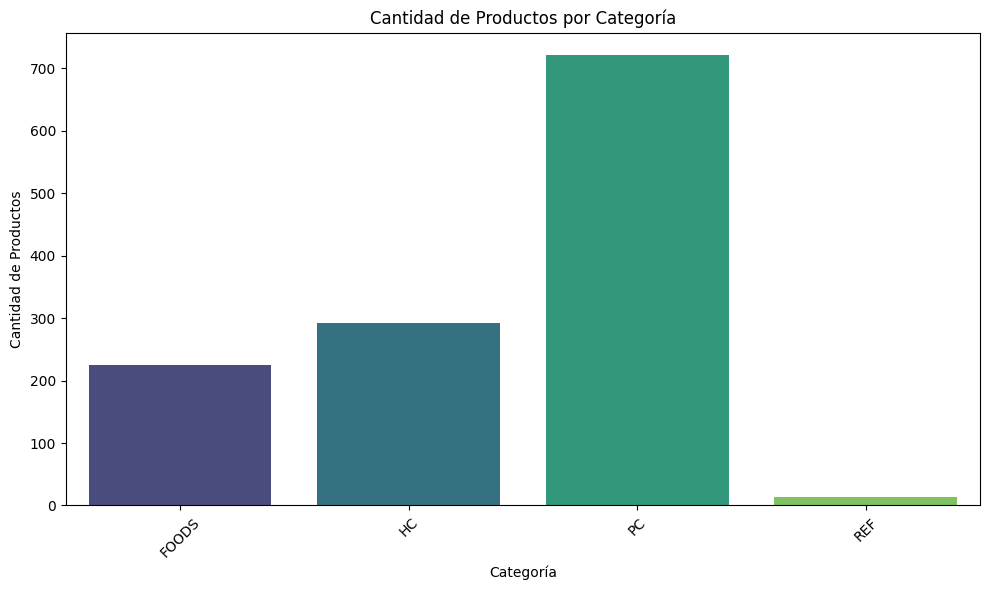

C:\Users\marco\AppData\Local\Temp\ipykernel_2660\3894928872.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='brand', y='cantidad', data=productos_marca, palette='viridis')


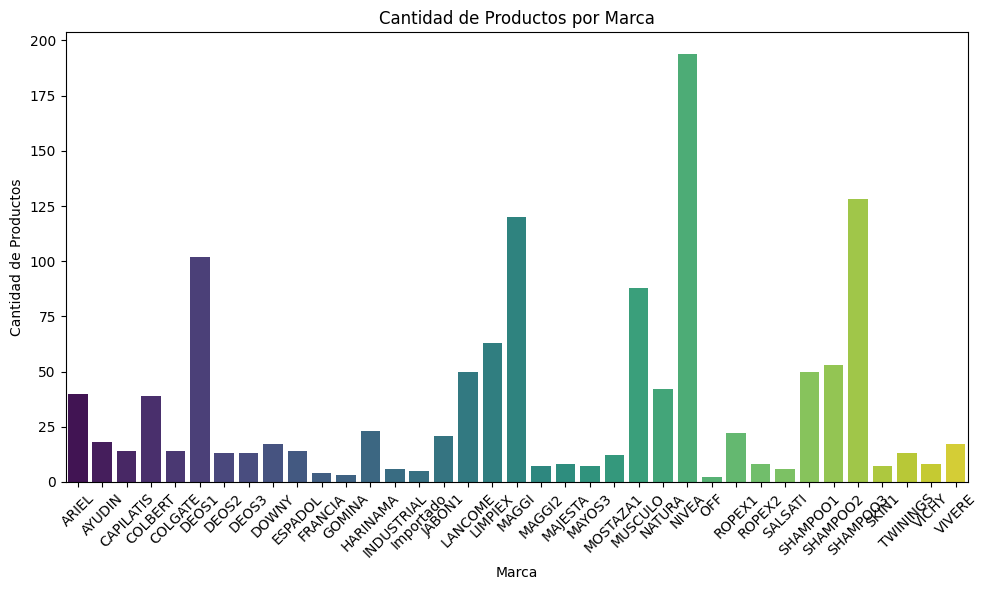

In [2]:
# Mostrar todos los productos únicos en el DataFrame 'productos' en unga grafica de barras segun su categoria
# Filtrar productos únicos
# Filtrar productos únicos
productos_unicos = productos.drop_duplicates(subset=['product_id'])
# Contar la cantidad de productos por categoría
productos_categoria = productos_unicos.groupby('cat1').size().reset_index(name='cantidad')
# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='cat1', y='cantidad', data=productos_categoria, palette='viridis')
plt.title('Cantidad de Productos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Productos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Mostrar todos los productos únicos en el DataFrame 'productos' en una grafica de barras segun su marca
# Filtrar productos únicos
productos_unicos = productos.drop_duplicates(subset=['product_id'])
# Contar la cantidad de productos por marca
productos_marca = productos_unicos.groupby('brand').size().reset_index(name='cantidad')
# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='brand', y='cantidad', data=productos_marca, palette='viridis')
plt.title('Cantidad de Productos por Marca')
plt.xlabel('Marca')
plt.ylabel('Cantidad de Productos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





#### Ventas

In [ ]:
#realizamos una grafica de ventas totales por periodo 
ventas_totales_por_periodo = df_sellin.groupby('periodo')['tn'].sum().reset_index()

#graficamos con matplotlib

plt.figure(figsize=(10, 6))
sns.barplot(x='periodo', y='tn', data=ventas_totales_por_periodo)
plt.title('Ventas Totales por Periodo')
plt.xlabel('Periodo')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:


# Definir ruta base
base_path = r'C:\Users\marco\OneDrive\Escritorio\UNIVERSIDAD AUSTRAL\MATERIAS\19_LAB_3'

# Leer los archivos
productos = pd.read_csv(os.path.join(base_path, 'tb_productos.txt'), sep='\t')
stocks = pd.read_csv(os.path.join(base_path, 'tb_stocks.txt'), sep='\t')
sellin = pd.read_csv(os.path.join(base_path, 'sell-in.txt'), sep='\t')

#creamos un dataframe para cada tabla
df_productos = pd.DataFrame(productos)
df_stocks = pd.DataFrame(stocks)
df_sellin = pd.DataFrame(sellin)

#convertimos perido formato fecha

df_stocks['periodo'] = pd.to_datetime(df_stocks['periodo'], format='%Y%m')
df_sellin['periodo'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')




#### Graficas de aproximacion

<Axes: title={'center': 'Ventas Totales por Periodo'}, xlabel='periodo'>

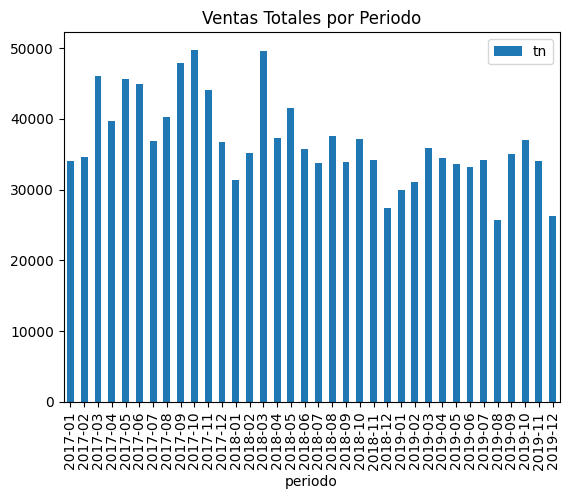

In [ ]:
#Graficamos la cantidad de productos por periodo
ventas_totales_por_periodo = df_sellin.groupby('periodo')['tn'].sum().reset_index()
ventas_totales_por_periodo['periodo'] = ventas_totales_por_periodo['periodo'].dt.strftime('%Y-%m')
ventas_totales_por_periodo.plot(x='periodo', y='tn', kind='bar', title='Ventas Totales por Periodo')


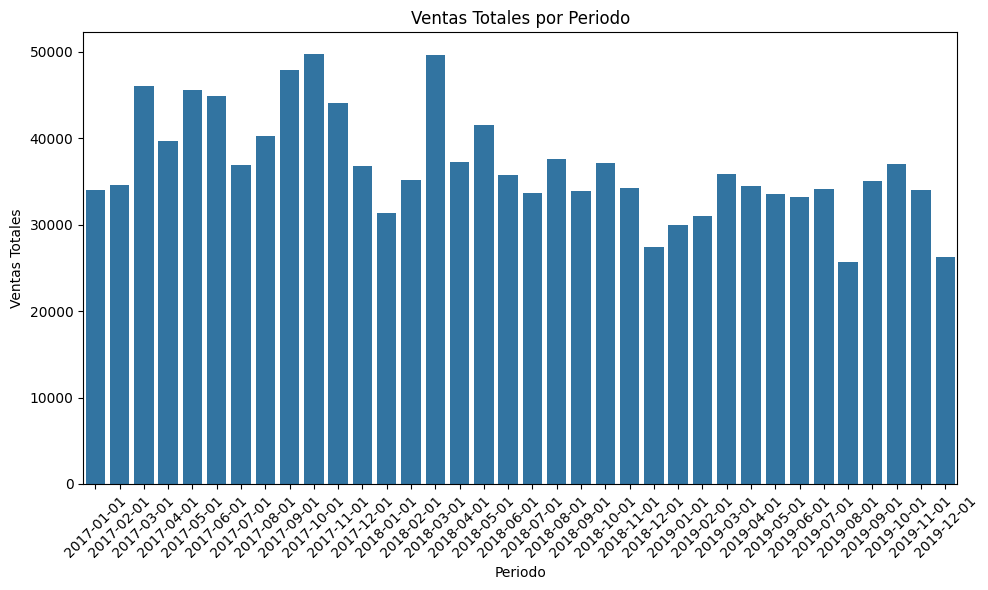

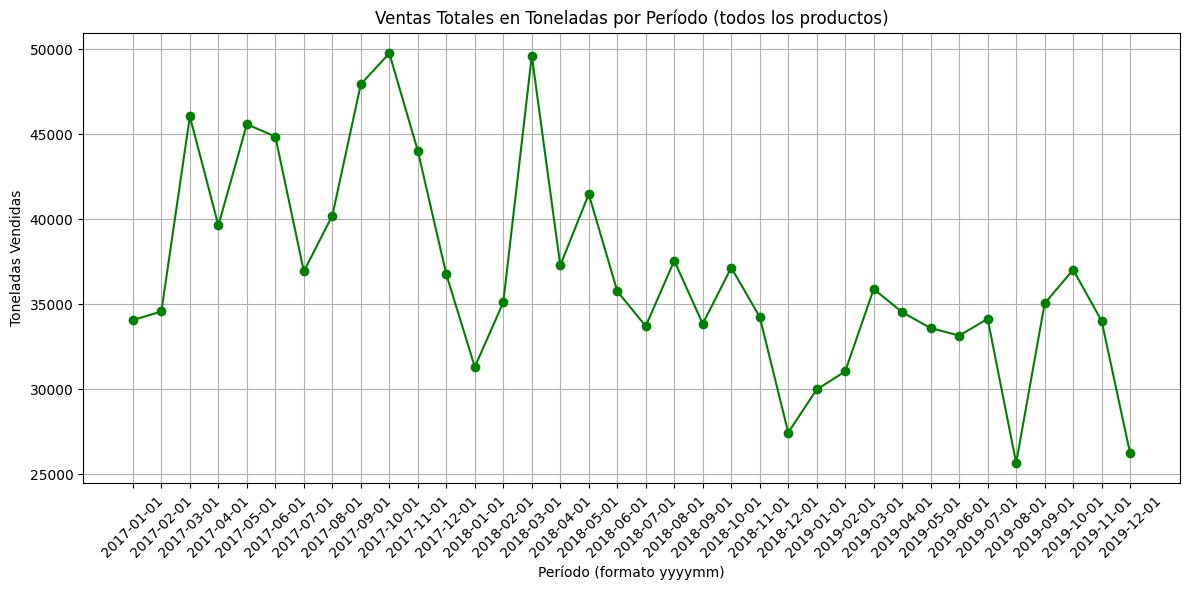

In [20]:
# Agrupar por período, sumando todas las toneladas vendidas
ventas_totales = df_sellin.groupby('periodo')['tn'].sum().reset_index()

# Asegurar que el período sea string para mejor visualización
ventas_totales['periodo'] = ventas_totales['periodo'].astype(str)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(ventas_totales['periodo'], ventas_totales['tn'], marker='o', linestyle='-', color='green')
plt.title('Ventas Totales en Toneladas por Período (todos los productos)')
plt.xlabel('Período (formato yyyymm)')
plt.ylabel('Toneladas Vendidas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


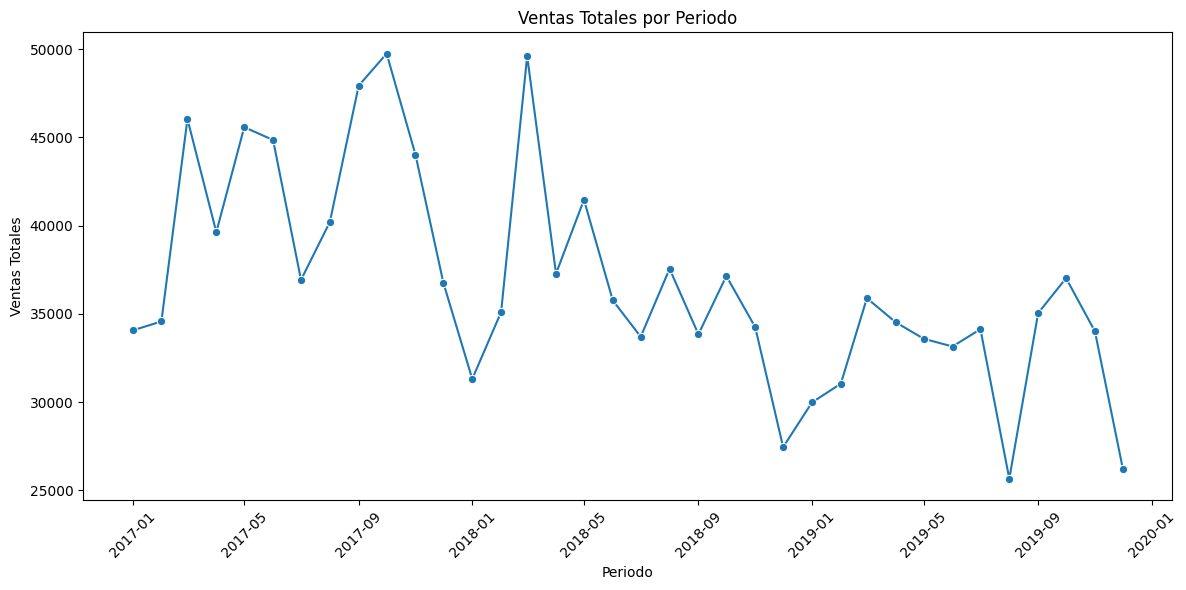

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='periodo', y='tn', data=ventas_totales_por_periodo, marker='o')
plt.title('Ventas Totales por Periodo')
plt.xlabel('Periodo')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

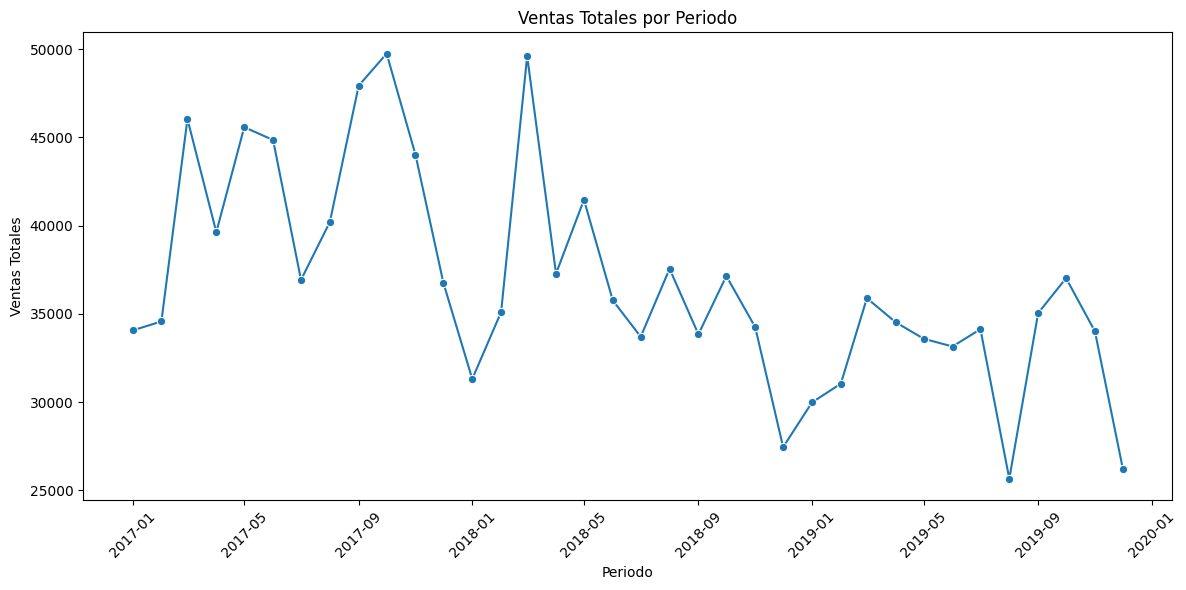

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='periodo', y='tn', data=ventas_totales_por_periodo, marker='o')
plt.title('Ventas Totales por Periodo')
plt.xlabel('Periodo')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Se descargaron los siguientes dataset del indec:
 1) “Índices y variaciones porcentuales mensuales e interanuales según divisiones de la canasta, bienes y servicios, clasificación de grupos. Diciembre de 2016 - abril de 2025”

In [ ]:
# Abrir el archivo CSV de serie_ipc_divisiones manejando posibles problemas de codificación
import pandas as pd
import sqlite3
import os

# Definir ruta base
base_path = r'C:\Users\marco\OneDrive\Escritorio\UNIVERSIDAD AUSTRAL\MATERIAS\19_LAB_3'
indices_path = os.path.join(base_path, 'serie_ipc_divisiones.csv')
try:
    indices = pd.read_csv(indices_path, sep=';', encoding='utf-8')
except UnicodeDecodeError:
    indices = pd.read_csv(indices_path, sep=';', encoding='latin1')

indices.head()
#indices['Descripcion'].unique()



,Codigo,Descripcion,Clasificador,Periodo,Indice_IPC,v_m_IPC,v_i_a_IPC,Region
0,0,NIVEL GENERAL,Nivel general y divisiones COICOP,201612,100,NaN,NaN,GBA
1,0,NIVEL GENERAL,Nivel general y divisiones COICOP,201612,100,NaN,NaN,Pampeana
2,0,NIVEL GENERAL,Nivel general y divisiones COICOP,201612,100,NaN,NaN,Noreste
3,0,NIVEL GENERAL,Nivel general y divisiones COICOP,201612,100,NaN,NaN,Noroeste
4,0,NIVEL GENERAL,Nivel general y divisiones COICOP,201612,100,NaN,NaN,Cuyo


In [8]:
import pandas as pd
import sqlite3

# 1. Leer el archivo IPIM
ipim_df = pd.read_csv("indice_ipim.csv", sep=";", encoding="utf-8", skip_blank_lines=True)

# 2. Convertir fecha a AAAAMM
ipim_df["periodo"] = pd.to_datetime(ipim_df["periodo"]).dt.strftime("%Y%m").astype(int)

# 3. Reemplazar coma decimal y convertir a float
ipim_df["indice_ipim"] = ipim_df["indice_ipim"].str.replace(",", ".").astype(float)

# 4. Pivotear para que cada apertura sea una columna
ipim_pivot = ipim_df.pivot_table(
    index="periodo",
    columns="nivel_general_aperturas",
    values="indice_ipim"
).reset_index()

# 5. Conectar con SQLite
conn = sqlite3.connect("base_relacional.db")

# 6. Leer la tabla de ventas
ventas_df = pd.read_sql_query("SELECT * FROM stocks", conn)

# 7. Hacer merge por periodo
ventas_ipim = ventas_df.merge(ipim_pivot, on="periodo", how="left")

# 8. Guardar como nueva tabla
ventas_ipim.to_sql("stocks_con_ipim_aperturas", conn, if_exists="replace", index=False)

# 9. Cerrar conexión
conn.close()

# 10. Mostrar una muestra
print(ventas_ipim.head())





   periodo  product_id  stock_final  0111_cereales_y_oleaginosas  \
0   201810       20524      1.61267                   313.350502   
1   201810       20311      2.93657                   313.350502   
2   201810       20654      6.83269                   313.350502   
3   201810       21005      1.01338                   313.350502   
4   201810       20974      0.34595                   313.350502   

   0112_hortalizas_y_legumbres  0113_frutas  011_agricolas  \
0                   316.308781   224.515183     295.494047   
1                   316.308781   224.515183     295.494047   
2                   316.308781   224.515183     295.494047   
3                   316.308781   224.515183     295.494047   
4                   316.308781   224.515183     295.494047   

   0121_ganado_vacuno_y_leche  0122_ganado_porcino_y_productos de granja  \
0                   218.93315                                 210.340122   
1                   218.93315                                 210.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Convertir la columna 'Periodo' a string para mejor visualización en el eje x
indices['Periodo_str'] = indices['Periodo'].astype(str)
# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(indices['Periodo_str'], indices['Indice_IPC'], marker='o', linestyle='-', color='blue')
plt.title('Índice de Precios al Consumidor (IPC) por Período')
plt.xlabel('Período (formato yyyymm)')
plt.ylabel('Índice de Precios al Consumidor (IPC)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
# vemos los tipos de descripcion de los indices
indices['Descripcion'].unique()




ModuleNotFoundError: No module named 'matplotlib.pyplot'

In [ ]:
indices['Descripcion'].unique()

NameError: name 'indices' is not defined

In [ ]:
import pandas as pd
import sqlite3
import os


# Convertir la columna 'fecha' a tipo datetime
indices['Periodo'] = pd.to_datetime(indices['Periodo'], format='%Y-%m')
# Agrupar por fecha y sumar las variaciones mensuales
indices_agrupados = indices.groupby('Periodo')['variacion_mensual'].sum().reset_index()
# Graficar las variaciones mensuales
plt.figure(figsize=(12, 6))
sns.lineplot(x='Periodo', y='variacion_mensual', data=indices_agrupados, marker='o')
plt.title('Variaciones Mensuales del IPC por Divisiones')
plt.xlabel('Periodo')
plt.ylabel('Variación Mensual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Graficar las variaciones mensuales del IPC por divisiones
plt.figure(figsize=(12, 6))
sns.lineplot(x='Periodo', y='variacion_mensual', data=indices_agrupados, marker='o')
plt.title('Variaciones Mensuales del IPC por Divisiones')
plt.xlabel('Periodo')
plt.ylabel('Variación Mensual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




NameError: name 'indices' is not defined

In [ ]:
# Abrir el archivo CSV de serie_ipc_divisiones manejando posibles problemas de codificación
try:
    indices = pd.read_csv(indices_path, sep=';', encoding='utf-8')
except UnicodeDecodeError:
    indices = pd.read_csv(indices_path, sep=';', encoding='latin1')

indices.head()

2) Canasta básica alimentaria y canasta básica total. Valores mensuales por adulto equivalente, expresados en pesos

#### 
3) “Series del índice de salarios. Números índice. Octubre de 2015 - marzo de 2025” 

#### Primeras aproximaciones - Ventas Totales por periodo

TRATAMIENTO DE TN=0

<Br>🔹 Cargar el archivo sell-in.txt
<Br>🔹 Detectar todas las combinaciones vivas de <product_id, customer_id>
<Br>🔹 Insertar ventas artificiales con tn = 0 para los periodos donde ambos están activos pero no se registró

In [3]:
import numpy as np

# Obtener los períodos de vida de cada producto
producto_periodos = sellin.groupby('product_id')['periodo'].agg(['min', 'max']).reset_index()
producto_periodos.columns = ['product_id', 'periodo_inicio_prod', 'periodo_fin_prod']

# Obtener los períodos de vida de cada cliente
cliente_periodos = sellin.groupby('customer_id')['periodo'].agg(['min', 'max']).reset_index()
cliente_periodos.columns = ['customer_id', 'periodo_inicio_cli', 'periodo_fin_cli']

# Crear todos los pares posibles de producto-cliente
prod_cli = pd.merge(
    sellin[['product_id', 'customer_id']].drop_duplicates(),
    producto_periodos,
    on='product_id'
)
prod_cli = pd.merge(
    prod_cli,
    cliente_periodos,
    on='customer_id'
)

# El período de vida conjunto es el máximo de los inicios y el mínimo de los finales
prod_cli['periodo_inicio'] = prod_cli[['periodo_inicio_prod', 'periodo_inicio_cli']].max(axis=1)
prod_cli['periodo_fin'] = prod_cli[['periodo_fin_prod', 'periodo_fin_cli']].min(axis=1)

# Generar todas las combinaciones posibles de (product_id, customer_id, periodo) dentro del rango de vida
rows = []
for _, row in prod_cli.iterrows():
    periodos = np.arange(row['periodo_inicio'], row['periodo_fin'] + 1)
    # Filtrar periodos válidos (YYYYMM)
    periodos = [p for p in periodos if (p % 100 >= 1 and p % 100 <= 12)]
    for periodo in periodos:
        rows.append((periodo, row['customer_id'], row['product_id']))

full_index = pd.DataFrame(rows, columns=['periodo', 'customer_id', 'product_id'])

# Unir con el sellin original para ver cuáles existen y cuáles no
sellin_key = sellin[['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'tn']]
merged = pd.merge(
    full_index,
    sellin_key,
    on=['periodo', 'customer_id', 'product_id'],
    how='left'
)

# Para las filas faltantes, completar con ceros y plan_precios_cuidados=0
for col in ['plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'tn']:
    if col in merged.columns:
        merged[col] = merged[col].fillna(0)

# El resultado es el nuevo DataFrame sellin con transacciones artificiales tn=0
sellin_full = merged

print(f"Cantidad original de transacciones: {len(sellin)}")
print(f"Cantidad nueva de transacciones: {len(sellin_full)}")
sellin_full.head()

NameError: name 'sellin' is not defined

In [ ]:
import pandas as pd

# Asumimos que ya generaste esto antes:
# sellin_full = merged con columnas tn, etc.

# Ordenar por producto, cliente y periodo
sellin_full = sellin_full.copy()
sellin_full['periodo'] = sellin_full['periodo'].astype(int)
sellin_full.sort_values(by=['product_id', 'customer_id', 'periodo'], inplace=True)

# Generar lags y la CLASE
def generar_lags(grupo):
    for i in range(12):
        grupo[f"tm-{i}"] = grupo['tn'].shift(i)
    grupo['CLASE'] = grupo['tn'].shift(-2)
    return grupo

sellin_lags = sellin_full.groupby(['product_id', 'customer_id']).apply(generar_lags)

# Quitar registros incompletos
sellin_lags = sellin_lags.dropna(subset=[f"tm-{i}" for i in range(12)] + ['CLASE']).reset_index(drop=True)

# Guardar a archivo final
sellin_lags.to_csv("dataset_lags_clase.txt", sep="\t", index=False)

print("✅ Dataset generado: dataset_lags_clase.txt")
